# Cannabis legalization effects on hard drugs trafficking and usage
#### By Nardine Abu-Nassar and Arie Stoliarsky

---

# Data preprocessing
## Section 1: Scope and overview of the Drug-Policy domain

#### Population
We define a sample of the population as a **country's status at a period of a year**, i.e. a country's legal, economical and drug related felonies aggregated by a single year.  
There are 201 countries with data over the years 2018-2022, which makes our population's size 1005 instances.

#### Variables
<u>The following is a list of **input variables**</u>:
- country (name): textual/categorical value. Contains 201 possible values.
- region: textual/categorical value. Contains the following values:
    - Europe
    - Africa
    - Asia
    - Oceania
    - North America
    - Central America
    - South America
- cannabis legalization status: categorical value. Contains the following values (will be discussed further in [section 4.2.1](#421---country-categorization):
    - LGL
    - MED
    - DEC
    - ILL
- decriminalization maximal possession amount: numerical/continuous values (analysis in [section 4.2.3](#423---analyzing-possession-limits-distribution-for-countries-with-decriminalization-policies))
- population: number of citizens living in the country in the year in question: numerical/continuous value. This value will also acts as normalization value for other variables
- border length: numerical continuous values: 
    - Divided into two categories - land border length in kilometers and shoreline length in kilometers. These variables may correlate with the amount of drug smuggling. It's also somewhat static data, since unless we factor major land exchanges, that didn't really happen in the selected timeline, it's going to be true throughout the years we explore.
- GDP: numerical/continuous value. Indicates economical strength, wealth and stability. Will be normalized per capita.
- Health budget: numerical/continuous value. Whenever possible, a country's health ministry's budget will be reported (in USD$), which could indicate how much the countries prioritize healthcare for its citizens, including combating implications of drug usage. Will be normalized by population.
- <u>Treatment cases in the population</u>: <b>This is our target variable</b>. This numerical value indicates what portion of citizens of a country (the number of cases normalized by population) are being treated for drug use by the healthcare system.
<br><br>
We hopefully could try to couple treatment statistics with policy changes and see the effect in usage of illicit drugs across time. We hypothesize that full legalization might lower hard drug use because of the legal alternative.
<br><br>
#### * * (due to lack of time, we were not able to finish processing some of the datasets at this stage. We'll showcase the changes in a future update.)


In [101]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
from pprint import pprint
from pathlib import Path
from typing import Union

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mutual_info_score
from sklearn.manifold import TSNE


from utils import vis_utils
import utils.dataset_processing_utils as dputil
from utils.dataset_processing_utils import print_discrepancies

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Section 2: load the datasets

---

#### sub-sections:
2.1) Download files:<BR>
    &emsp;2.1.1) From the [UNODC site](https://www.unodc.org/unodc/en/data-and-analysis/wdr2024-annex.html):<BR>
    &emsp;&emsp;2.1.1.a) 7.1._Drug_seizures_2018-2022.xlsx<BR>
    &emsp;&emsp;2.1.1.b) 10.1._Drug_related_crimes.xlsx<BR>
    &emsp;&emsp;2.1.1.c) 5.1_Treatment_by_primary_drug_of_use.xlsx<BR>
    &emsp;2.1.2) From Kaggle download the [legalization status dataset](https://www.kaggle.com/datasets/venusrosario/legality-of-cannabis/)     <BR>
    &emsp;2.1.3) Also from Kaggle download the [CIA FactBook data](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)     <BR>
    &emsp;2.1.4) From the WorldBankGroup website, we arranged the collected the data in the timescale we require and exported it into wbg_pop_health_gdp.csv<BR>

2.2) Change the names for our ease of use:<BR>
    &emsp;2.2.1) 7.1._Drug_seizures_2018-2022.xlsx --> unodc_drug_seizures.xlsx<BR>
    &emsp;2.2.2) 10.1._Drug_related_crimes.xlsx --> unodc_drug_crime_counts.xlsx<BR>
    &emsp;2.2.3) 5.1_Treatment_by_primary_drug_of_use.xlsx --> unodc_drug_treatment.xlsx<BR>
    &emsp;2.2.3) Legality_of_cannabis.csv --> legalization.csv<BR>

2.3) Manual feature engineering - further explanation in [section 3](#section-3-manual-feature-engineering-for-legalizationcsv)

2.4) Load data into pandas Dataframes


In [2]:
# Defining constants
if os.name == 'nt':  # in case of MS Windows
    data_path = Path(f"{os.getcwd()}\\data\\")
else:  # Linux or Mac
    data_path = Path(f"{os.getcwd()}/data/")

# rename files
if os.path.isfile(data_path.joinpath('7.1._Drug_seizures_2018-2022.xlsx')):
    os.rename(data_path.joinpath('7.1._Drug_seizures_2018-2022.xlsx'), data_path.joinpath('unodc_drug_seizures.xlsx'))
if os.path.isfile(data_path.joinpath('10.1._Drug_related_crimes.xlsx')):
    os.rename(data_path.joinpath('10.1._Drug_related_crimes.xlsx'), data_path.joinpath('unodc_drug_crime_counts.xlsx'))
if os.path.isfile(data_path.joinpath('5.1_Treatment_by_primary_drug_of_use.xlsx')):
    os.rename(data_path.joinpath('10.1._Drug_related_crimes.xlsx'), data_path.joinpath('unodc_drug_treatment.xlsx'))
if os.path.isfile(data_path.joinpath('Legality_of_cannabis.csv')):
    os.rename(data_path.joinpath('Legality_of_cannabis.csv'), data_path.joinpath('legalization.csv'))


In [3]:
# load into pandas DataFrame:
seizures_df = pd.read_excel(data_path.joinpath('unodc_drug_seizures.xlsx'), header=1, engine='calamine')
seizures_df.head()

,Region,SubRegion,Country,DrugGroup,DrugSubGroup,DrugName,Reference year,Kilograms,msCode
0,Africa,East Africa,Kenya,Amphetamine-type stimulants (excluding “ecstasy”),Methamphetamine,Methamphetamine,2022,10.84,KEN
1,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),Cannabis herb (marijuana),2022,8474.41,KEN
2,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,Cannabis plants,2022,2534.40,KEN
3,Africa,East Africa,Kenya,Cocaine-type,Cocaine,Cocaine hydrochloride,2022,10.99,KEN
4,Africa,East Africa,Kenya,Opioids,Opiates,Heroin,2022,38.94,KEN


In [4]:
crime_counts_df = pd.read_excel(data_path.joinpath('unodc_drug_crime_counts.xlsx'), engine='calamine')
crime_counts_df.head()

,Region,SubRegion,Country,campaign,Year,Type of offence,Drug,Calculated total,Reported total,Males,Females,Adults,Juveniles,Unknown/Other/ Third/Intersex,Specify year if other,Adults: 18 and older,Juveniles: under 18 years old,msCode
0,Africa,West and Central Africa,Ghana,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Yes,Yes,GHA
1,Europe,Western and Central Europe,Gibraltar,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,GIB
2,Asia,East and South-East Asia,"China, Macao SAR",ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,MAC
3,Americas,South America,Venezuela (Bolivarian Republic of),ARQ2022,2022,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,VEN
4,Africa,North Africa,Algeria,HIST2018,2018,Offences related to drug trafficking,Other opioids not under international control,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Yes,DZA


In [5]:
treatments_df = pd.read_excel(data_path.joinpath('unodc_drug_treatment.xlsx'), engine='calamine', header=1)
treatments_df.head()

,Region,SubRegion,Country,msCode,Reference year,DrugGroup,Drug,Sex,Value,Campaign,Coverage
0,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Females,2,ARQ2021,NaN
1,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Males,2,ARQ2021,NaN
2,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Total,4,ARQ2021,NaN
3,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Females,8,ARQ2021,NaN
4,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Males,81,ARQ2021,NaN


In [6]:
legalization_df = pd.read_csv(data_path.joinpath('legalization.csv'), encoding='utf-16')
legalization_df.head()

,Country/Territory,Recreational,Recreational_year,Medical,Mediacal_year,Decriminalized_max_possession,Notes
0,Afghanistan,Illegal,NaN,Illegal,NaN,NaN,Production banned by King Zahir Shah in 1973.
1,Albania,Illegal,NaN,Legal,2023.0,NaN,Prohibited but plants highly available through...
2,Algeria,Illegal,NaN,Illegal,NaN,NaN,NaN
3,Andorra,Illegal,NaN,Illegal,NaN,NaN,NaN
4,Angola,Illegal,NaN,Illegal,NaN,NaN,NaN


In [7]:
borders_df = pd.read_csv(data_path.joinpath('cia_factbook.csv'), encoding='utf-8')
borders_df.head()

,Country,Geography: Land boundaries - total,Geography: Coastline
0,Afghanistan,"5,987 km",0 km (landlocked)
1,Akrotiri,NaN,NaN
2,Albania,691 km,362 km
3,Algeria,"6,734 km",998 km
4,American Samoa,0 km,116 km


In [8]:
demographics_df = pd.read_csv(data_path.joinpath('wbg_pop_health_gdp.csv'), encoding='latin-1')
demographics_df.head()

,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024],Unnamed: 12,Unnamed: 13
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,35688935,36743039,37856121,39068979,40000412,40578842,41454761,..,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,18753456498,18053222687,18799444490,19955929052,14259995441,14497243872,17233051620,..,NaN,NaN
2,Afghanistan,AFG,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,12.62081718,14.20841885,14.83131981,15.53361416,21.508461,23.0881691,..,..,NaN,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,2873457,2866376,2854191,2837849,2811666,2777689,2745972,..,NaN,NaN
4,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,13019726212,15379509892,15585105131,15241458745,18032010564,19017242586,23547179830,..,NaN,NaN


---

## Section 3: Manual feature engineering
### 3.1 - legalization.csv

There was crucial information missing - the years when legislation had changed.
Therefore, using the **Notes** column, which contains diverse information, including years when countries changed legislation.
Additionally, it contains data about the maximum amount of cannabis that a citizen can have on his possession without receiving a penalty (in grams).

As such, we manually had created three new columns - *Recreational_year* (integer) and *Medical_year* (integer) which indicate the year the legislation
was enacted in, according to of our category, and *Decriminalized_max_possession* (float) that indicates the maximum amount of possession of cannabis on a person is allowed in a country (in grams).

We validated our manual work with reference to other Wikipedia pages and Google's Gemini for further consultation.

---

### 3.2 - cia_factbook.csv

The original CIA FactBook data had contained 980 columns. We have extracted only the necessary columns, which are the country's name, its border and shoreline length. Furthermore, although we hadn't had the time to do so, we would like to in perpetration for the final report convert the textual data for the borders into numerical data by omitting any non-numerical value from it.

## Section 4: Initial analysis of each dataframe

### sub-section 4.1: _unodc_seizures_

#### Key features:

- Region (as a way to aggregate countries)
- Country (as a key to merge between datasets, and as the most basic geographical entity)
- DrugGroup (mainly used to merge this dataset with the drug_crime dataset)
- DrugSubGroup (as an indicator of the drug type)
- Reference Year (for the timeseries analysis)
- Kilograms (our target variable)

Accordingly - the following features will be dismissed:
- SubRegion (less known than continent, and region is a good enough aggregate) - However it does help us differentiate between North, Central and South America.
- DrugName (too specific, making the number of categories too large - see figure 4.1.1)
- msCode (another way of writing the country's name)

#### 4.1.1 - drug type categorization (_DrugName_, _DrugGroup_, _DrugSubGroup_ variables)

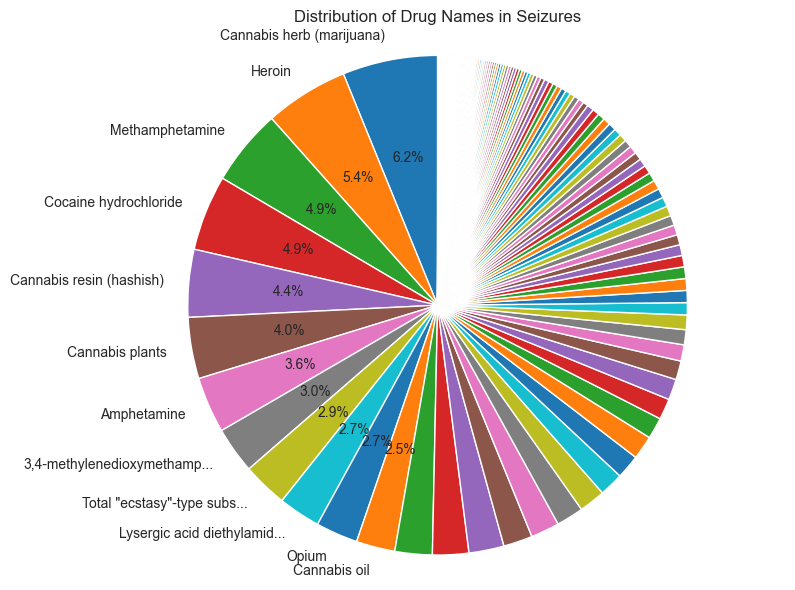

In [9]:
# extract the drug names and their counts
drugNames = seizures_df["DrugName"].value_counts()

# Calculate percentages
total = drugNames.sum()
percentages = 100 * drugNames / total

# Create shortened labels
MAX_LABEL_LENGTH = 25
labels = []
for drug_name, pct in zip(drugNames.index, percentages):
    if pct >= 2.5:  # Only show labels for segments ≥ 2.5%
        # Truncate long labels
        if len(drug_name) > MAX_LABEL_LENGTH:
            labels.append(drug_name[:MAX_LABEL_LENGTH] + "...")
        else:
            labels.append(drug_name)
    else:
        labels.append('')  # Empty string for small segments

# Create a figure
plt.figure(figsize=(8, 6))

# Create pie chart with truncated labels
plt.pie(drugNames.values,
        labels=labels,
        autopct=lambda pct: f'{pct:.1f}%' if pct >= 2.5 else '',
        startangle=90)

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Add title
plt.title('Distribution of Drug Names in Seizures')

# Show plot
plt.tight_layout()
plt.show()


As it can be seen in the pie-chart above, the distribution of drug types is almost uniform, and contains a large variety of values. Thus, making this variable less informative that its higher-level counterpart _DrugSubGroup_ a more viable candidate than it.

On the other hand, as it could be observed below, using only _DrugGroup_ is too general, for example - it aggregates different types of cannabis type drugs together, some of them don't apply under the legalization status in most cases (i.e. Hashish). Therefore, making _DrugSubGroup_ an essential variable for indicating the drug type category.

To handle the removal of this feature, we are going to aggregate _Kilograms_ by summing it for all _DrugNames_.

#### 4.1.2: Selecting sub-group of hard drugs to use in our study

This is going to be achieved by counting for each _DrugGroup_ the amount of instances in our dataset

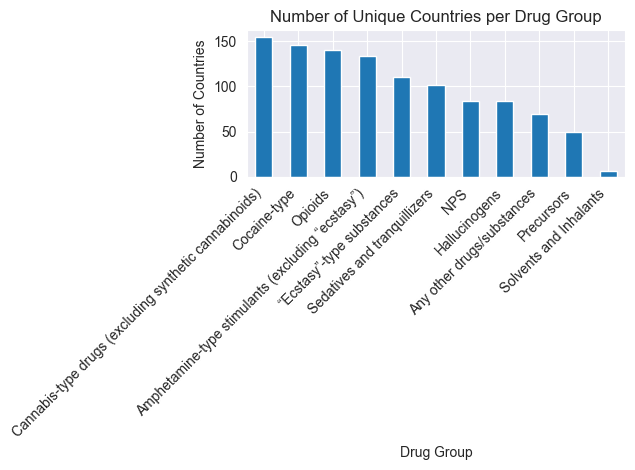

In [10]:
# Count unique countries per drug group
country_counts = seizures_df.groupby('DrugGroup')['Country'].nunique().sort_values(ascending=False)

# Plot the bar chart
plt.figure()
country_counts.plot(kind='bar')
plt.xlabel('Drug Group')
plt.ylabel('Number of Countries')
plt.title('Number of Unique Countries per Drug Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the bar-plot above, we can see that except cannabis-type, which are considered _light_ drugs, all other types between Cocaine and Hallucinogens will be considered in out case (with one exception).

The following drugs are dismissed:
- *Any other drugs/substances*: It is too general, and we cannot determine whether these substances are considered hard drugs.
- *Percursors* and *Solvents and Inhalants*: There is more than half the countries which don't gather data on these, and the countries that do gather data on them are insignificant to our analysis.
- *NPS*: This is the UNODCs definition of NPS:


> A New Psychoactive Substance (NPS) is a substance of abuse, either in a pure form or a
> preparation, that is not controlled by the 1961 Single Convention on Narcotic Drugs or the
> 1971 Convention on Psychotropic Substances, but which may pose a “public health threat”. In
> this context, the term “new” does not necessarily refer to novel inventions but to substances
> that have recently become available.
> Since their emergence, NPS have been known in the market by terms such as "designer drugs",
> "legal highs", "herbal highs", and/or "bath salts". The term “designer drugs” had been
> traditionally used to identify synthetic substances. However, it has recently been broadened
> to include other psychoactive substances that mimic the effects of illicit and prescription
> drugs.

This category consists of the drugs listed below. As it can be seen, it comprised of various types of drugs like synthetic cannabinoids, mushrooms and Ketamine, all from seemingly different categories (mushrooms are hallucinogens, Khat is as light as cannabis or even close to tobacco, etc.). Additionally, by the definition above, these substances are hard enough to define, **therefore we are going to truncate these rows.**

In [11]:
nps = seizures_df[seizures_df["DrugGroup"] == "NPS"]["DrugName"].value_counts()
nps

DrugName
Ketamine and phencyclidine-type substances    194
Khat                                          104
Synthetic cathinones                           51
Synthetic cannabinoids (“Spice”)               49
Mushrooms (hallucinogenic)                     38
Kratom (Mitragyna speciosa)                    37
Synthetic cannabinoids (Spice)                 29
Non-specified NPS                              13
Alpha-Pyrrolidinohexiophenone (alpha-PHP)      12
Phenethylamines                                12
2C (psychedelics)                               9
Salvia divinorum                                9
Piperazines                                     8
MDMB-CHMICA                                     7
Ayahuasca                                       7
Tryptamines                                     6
JWH-210                                         6
4-Fluoromethamphetamine (4-FMA)                 5
2,5-Dimethoxy-4-chloroamphetamine (DOC)         4
Pentedrone                               

---
#### 4.1.3 - transformation according to previous sections:

4.1.3.1) Use *SubRegion* to enrich the *Region* values for the Americas region. <BR>
4.1.3.2) Truncate *DrugName*, *SubRegion*, *Recreational*, *Medical* and *msCode* columns <BR>
4.1.3.3) Remove rows under the values that we considered irrelevant in [section 4.1.2](#412-selecting-sub-group-of-hard-drugs-to-use-in-our-study) <BR>
4.1.3.4) Aggregate the rows by summing on the *Kilograms* column <BR>
4.1.3.5) Change the column names according to this schema: <BR>
| Original name | New name |
| --- | --- |
| Country | country |
| Region | region |
| DrugGroup | drug_group |
| DrugSubGroup | drug_sub_group |
| Reference year | seizure_reference_year |
| Kilograms | seizure_volume |

During this process we transformed our **dataframe's dimension** from **11015x9** to **5933x4**

In [12]:
# 4.1.3.0 - Copy original df to temporary one for staging
trunc_seizures_df = seizures_df.copy()

# 4.1.3.1 - Use SubRegion to differentiate between South, Central and North America
trunc_seizures_df['Region'] = trunc_seizures_df.apply(lambda x: x['SubRegion'] if "America" in x["SubRegion"] else x["Region"], axis=1)
trunc_seizures_df['Region'] = trunc_seizures_df.apply(lambda x: "Central America" if "Americas" in x["Region"] else x["Region"], axis=1)

# 4.1.3.2 - Truncate columns:
trunc_seizures_df = trunc_seizures_df[['Region', 'Country', 'DrugGroup', 'DrugSubGroup', 'Reference year' ,'Kilograms']]

# 4.1.3.3 - Remove ["Any other drugs/substances", "Precursors", "Solvents and Inhalants", "NPS"] values of the DrugGroup column
drug_groups_to_filter = ["Any other drugs/substances", "Precursors", "Solvents and Inhalants", "NPS"]
trunc_seizures_df = trunc_seizures_df.query("DrugGroup not in @drug_groups_to_filter")

# 4.1.3.4 - Aggregate Kilograms by summing values
final_seizures_df = trunc_seizures_df.groupby(['Region', 'Country', 'DrugGroup', 'DrugSubGroup', 'Reference year']).agg({'Kilograms': 'sum'}).reset_index()

# 4.1.3.5 - change names of columns according to the schema
column_name_mapping = {
    'Country': 'country',
    'Region': 'region',
    'DrugGroup': 'drug_group',
    'DrugSubGroup': 'drug_sub_group',
    'Reference year': 'seizure_reference_year',
    'Kilograms': 'seizure_volume'
}
final_seizures_df = final_seizures_df.rename(columns=column_name_mapping)

# display final dataframe of seizures data:
print(final_seizures_df.shape)
final_seizures_df.sample(5, random_state=SEED)

(5935, 6)


,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume
4306,Europe,Romania,Amphetamine-type stimulants (excluding “ecstasy”),Amphetamine,2021,8.3776
1983,Asia,Singapore,Opioids,Pharmaceutical opioids,2018,0.0000
1393,Asia,Israel,Cannabis-type drugs (excluding synthetic canna...,Cannabis oil,2021,11.5000
3471,Europe,Iceland,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2021,141.3230
3954,Europe,Netherlands,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2019,5378.0000


---

#### 4.1.3 - EDA - Exploring _Kilograms_ - Our target variable

_Kilograms_ indicates the total amount of drugs (of some type) that has been seized at one country over one year (in kilograms). Below is the distribution of Seized kilograms of drugs by continent and by drug_group:

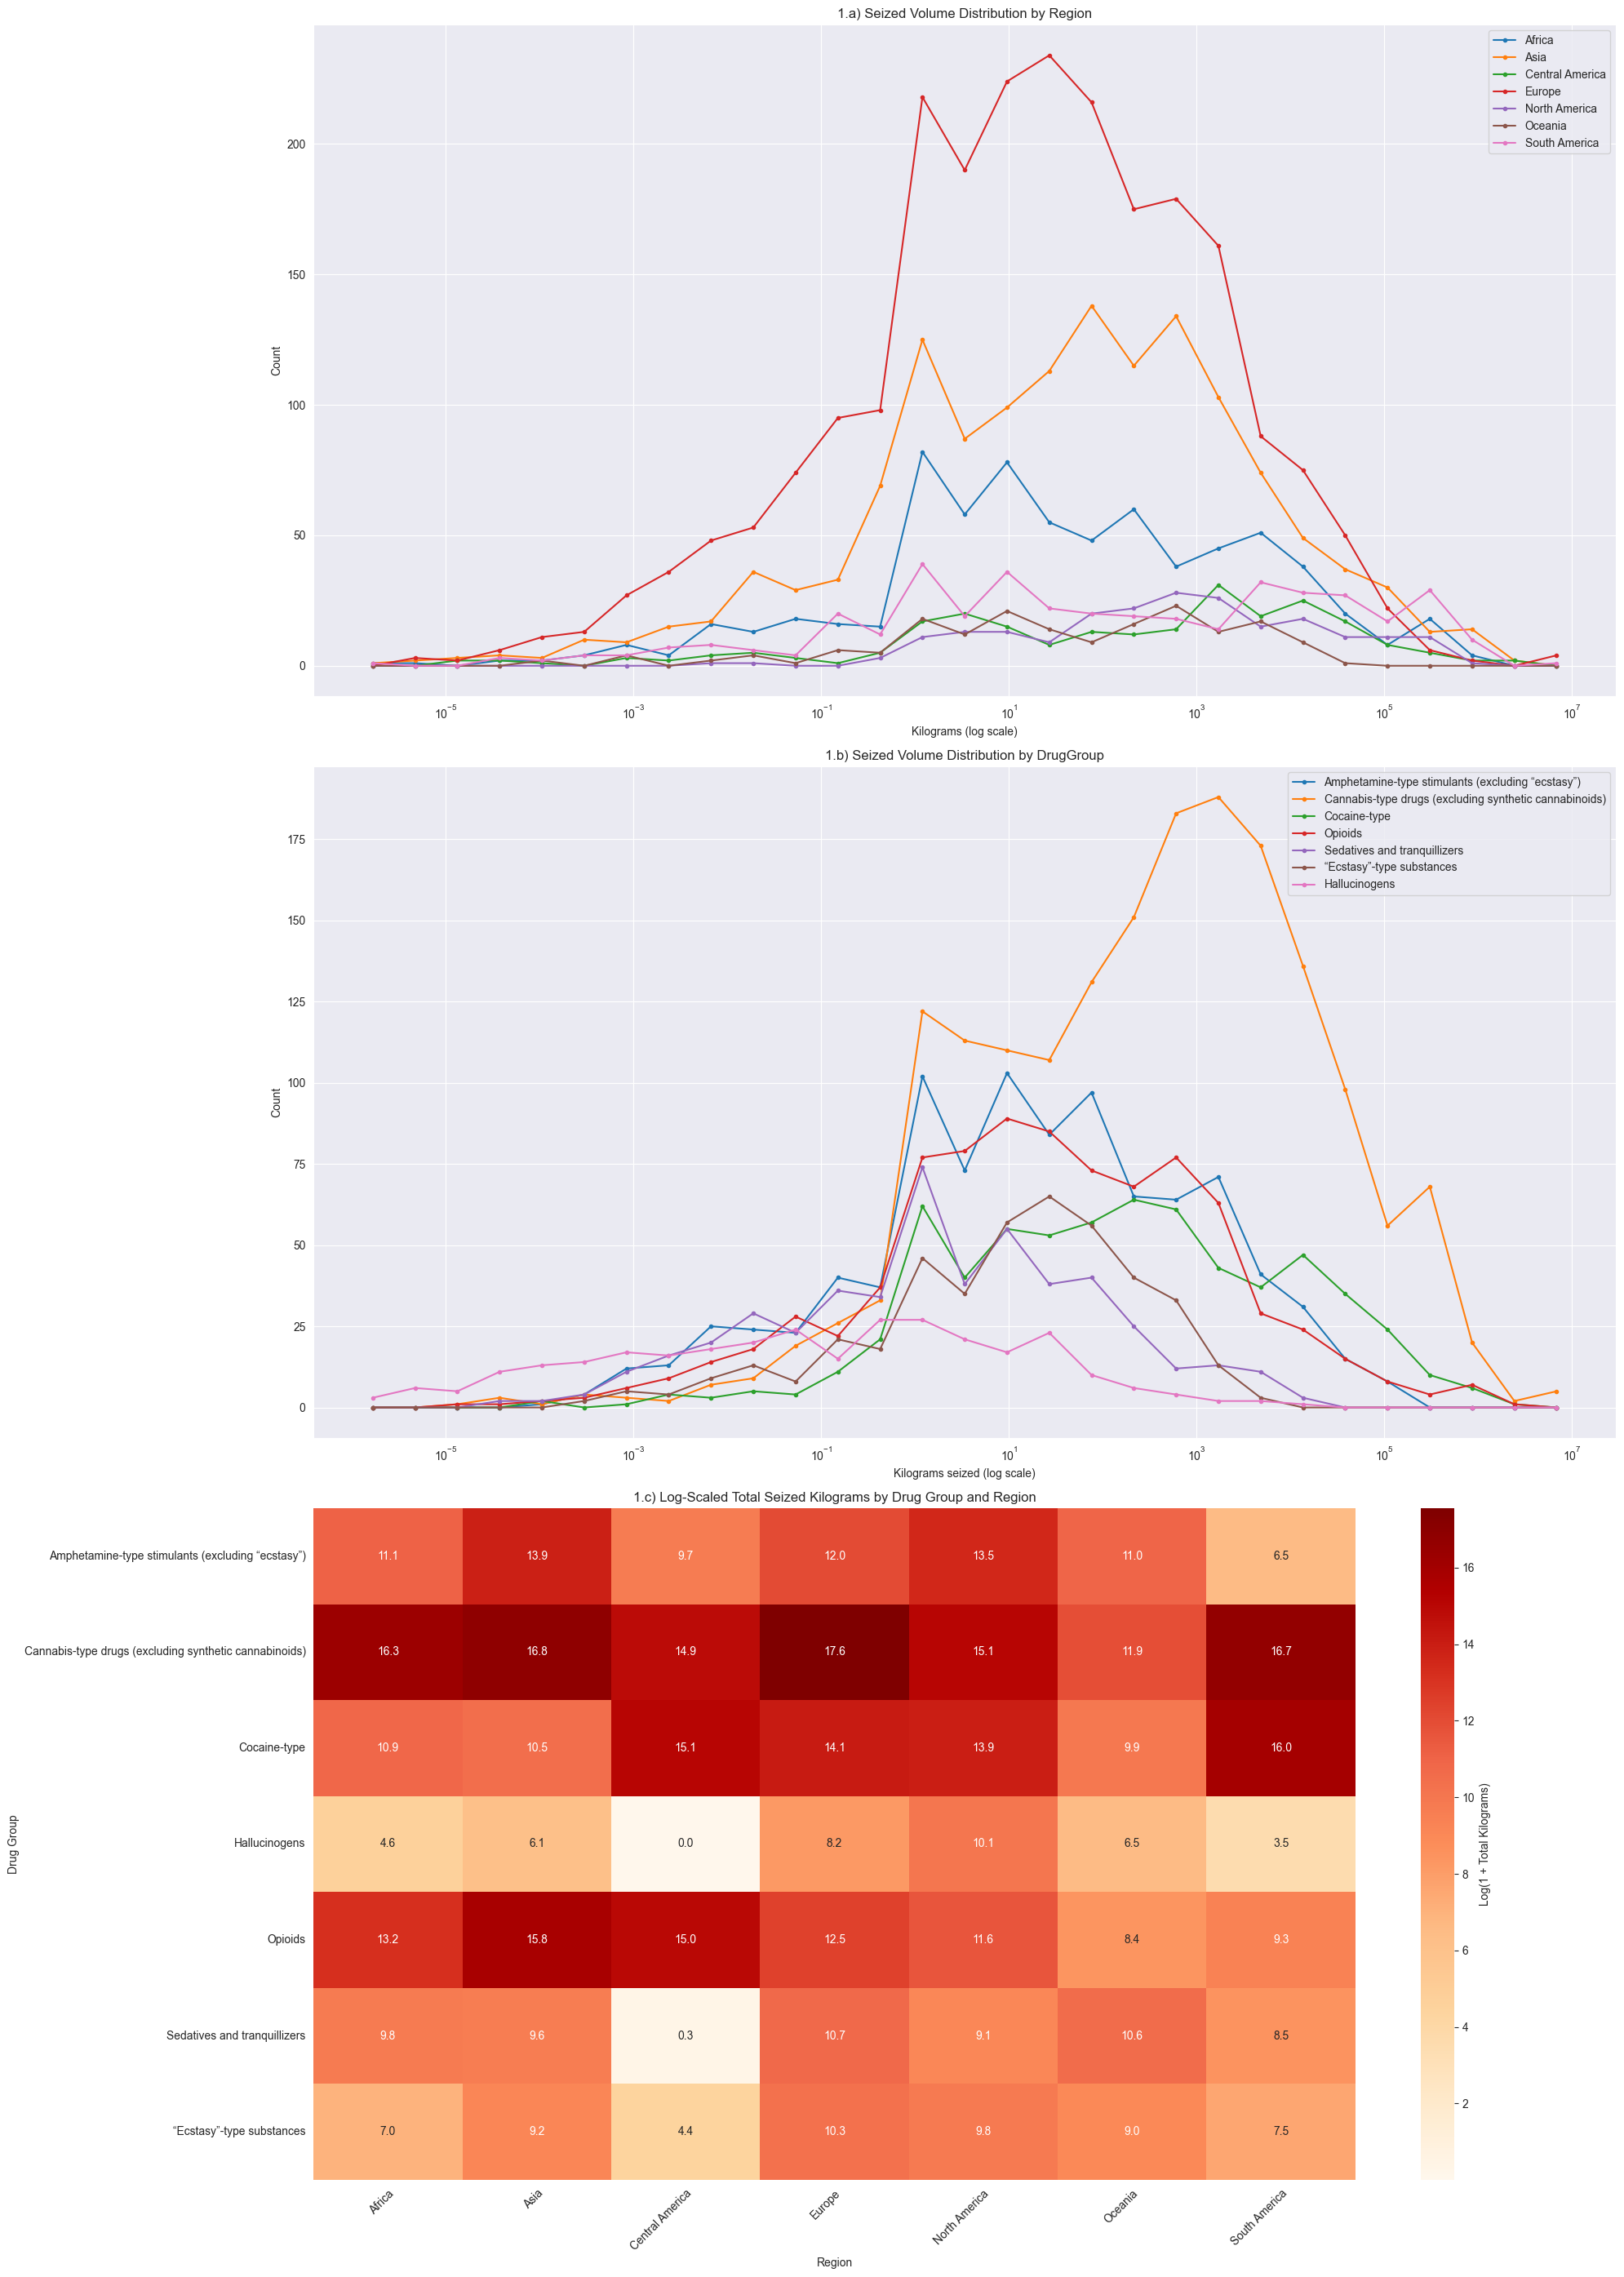

In [13]:
# Define bins for Kilograms using log scale
bins = np.logspace(np.log10(final_seizures_df['seizure_volume'].min() + 1e-6), np.log10(final_seizures_df['seizure_volume'].max()), 30)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 28))

# Plot for Region
for region in final_seizures_df['region'].unique():
    counts, _ = np.histogram(final_seizures_df[final_seizures_df['region'] == region]['seizure_volume'], bins=bins)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])
    ax1.plot(bin_centers, counts, marker='o', linestyle='-', markersize=3, label=region)
ax1.set_xlabel('Kilograms (log scale)')
ax1.set_ylabel('Count')
ax1.set_xscale('log')
ax1.set_title('1.a) Seized Volume Distribution by Region')
ax1.legend()

# Plot for DrugGroup
for drug_group in final_seizures_df['drug_group'].unique():
    counts, _ = np.histogram(final_seizures_df[final_seizures_df['drug_group'] == drug_group]['seizure_volume'], bins=bins)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])
    ax2.plot(bin_centers, counts, marker='o', linestyle='-', markersize=3, label=drug_group)
ax2.set_xlabel('Kilograms seized (log scale)')
ax2.set_ylabel('Count')
ax2.set_xscale('log')
ax2.set_title("1.b) Seized Volume Distribution by DrugGroup")
ax2.legend()

# Plot the relation: Heatmap of total Kilograms by DrugGroup and Region
# Pivot the table to get total kilograms for each DrugGroup and Region combination
try:
    pivot_table = final_seizures_df.pivot_table(
        values='seizure_volume',
        index='drug_group',
        columns='region',
        aggfunc='sum',  # Sum of kilograms
        fill_value=0    # Fill missing combinations with 0
    )

    # Transform the pivot_table to a log scale for the heatmap
    # Using np.log1p to handle potential zeros (log(1+x))
    # This ensures that 0 values become log(1) = 0, and small positive values are handled appropriately.
    log_pivot_table = np.log1p(pivot_table)

    # Plot the heatmap on ax3 using the log-scaled data
    if not log_pivot_table.empty: # Check the transformed table
        sns.heatmap(log_pivot_table, annot=True, fmt=".1f", cmap="OrRd", ax=ax3, cbar_kws={'label': 'Log(1 + Total Kilograms)'})
        ax3.set_title('1.c) Log-Scaled Total Seized Kilograms by Drug Group and Region') # Updated title for clarity
        ax3.set_xlabel('Region')
        ax3.set_ylabel('Drug Group')
        # Rotate x-axis labels for better readability if there are many regions
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    else:
        ax3.text(0.5, 0.5, "Not enough data to create log-scaled heatmap", ha='center', va='center') # Updated message

except Exception as e:
    ax3.text(0.5, 0.5, f"Error creating heatmap: {e}", ha='center', va='center', wrap=True)
    
# Adjust layout
plt.tight_layout()
plt.show()

### Summary:
#### Figure 1.a:

From the distribution we can see that **largest mass** of drug seizures was reported in **Europe**, we think this is due to one of the following reasons:

1. European countries may be more politically inclined to report such incidents.
2. Europe's economic strength may affect the number of potential clients. However, we do need to consider that wealth doesn't mean people are more incline to purchase drugs.
3. Due to the Schengen agreement, it is relatively easier to transport drugs across the region. 
4. Europe's sentencing is less severe (in most cases) than other regions (several years in jail vs. death sentences).

Furthermore - if we aggregate all the regions in America, we will probably see that it'll have a massive lead in larger quantities caught.

#### Figure 1.b:

Key points from the distribution of volume by drug group are the following:

1. There is a large surge in volume after the 2-3 kilogram mark. We speculate that it is harder to seize drugs in low quantities or it is just not reported as frequently.
2. We see that the **most popular** drug-type that is being confiscated is **cannabis** - which is probably due to its popularity and because it is considered a "light" drug - which means it is more likely to be decriminalized or get a less harsh sentence. Moreover, it is produced in many countries, some of them in industrial scale of production (unlike most other drug types where any production is illegal).
3. There are shifts in the 2nd most popular drug between amphetamines, opioids and cocaine. Notably in higher quantities **cocaine** seems to be the most prevalent. This could indicate the production of cocaine is more massive and/or the demand for it is larger.

#### Figure 1.c:

When studying the relationship between Region and drug_group we see some correlation between the region of production of the drug and the region of the seizures.
<BR>
For example - Cocaine is predominantly produced in South American countries like Colombia. Likewise, opioids are manufactured at scale in countries in Asia such as Afghanistan.
<BR>
This could indicate one of two possibilities, or both:
1. Drugs traffickers are getting caught in the countries of production.
2. The drug trade is less global as we thought.

<BR>

**Note** - For future analysis, we do want to see what is the effect in countries with some legalization status (decriminalization at the least) on their cannabis traffic.


---

## sub-section 4.2 - legalization.csv

### 4.2.1 - Country categorization:
In order to examine how legislation on the subject of cannabis affects drug follow in the respected countries, we first devise the following 4 groups of countries, and their current legal state on cannabis (see the table below):

| Category | Category abbreviation | Recreational legal status | Medical legal status |
| --- |-----------------------|---------------------------|----------------------|
| Prohibition | ILL                   | Illegal                   | Illegal              |
| Decriminialized | DEC |  Decriminalized           | Illegal              |
| Medically legal | MED | Decriminalized/Illegal | Legal/CBD only       |
| Full legality | LGL | Legal | Legal                |

**Note** - For decriminalization policies - we do have to differentiate between the volume of drugs one citizen can have have on his possession, as it will be accounted for when pairing it with the drug seizures data. Mainly, we speculate that some of these incidents may not be recorded due to this.

Additionally, we will also remove the 'Notes' as it is no longer necessary after the manual processing in [Section 3](#section-3-manual-feature-engineering-for-legalizationcsv)
We also need to dismiss of North Korea, as they're the only country with the value of 'Unknown' (Probably since they did not disclose information to the UN)

Finally - we arrange, rename according to the schema and the columns and remove unnecessary columns - _Notes_, _Recreational_ and _Medical_

In [14]:
def legal_status_categorization(row: pd.Series) -> str:
    """A simple switch case to categorize a pandas dataframe row to one of 4 categories:
    1. LGL - 'Recreational' column has the value 'Legal'.
    2. MED - 'Recreational' column is either 'Illegal' or 'Decriminalized', and 'Medical' column has one of the following values: 'Legal' or 'CBD only'.
    3. DEC - 'Recreational' column has the value 'Decriminalized'. 'Medical' has the value 'Illegal'.
    4. ILL - 'Recreational' and 'Medical' columns both have the value 'Illegal'.
    """
    if row['Recreational'] == 'Legal':
        return 'LGL'
    elif row['Medical'] in ['CBD only', 'Legal']:
        return 'MED'
    elif row['Recreational'] == 'Decriminalized' and row['Medical'] == 'Illegal':
        return 'DEC'
    else:
        return 'ILL'

legalization_df['legal_category'] = legalization_df.apply(lambda row: legal_status_categorization(row), axis=1)
# Drop rows with 'Unknown' values
legalization_df = legalization_df.query('Recreational != "Unknown" | Medical != "Unknown"')

# reorder the columns for better visualization:
col_name_mapping = {
    "Country/Territory": "country",
    "Recreational_year": "recreational_year",
    "Mediacal_year": "medical_year",
    "Decriminalized_max_possession": "decriminalized_max_possession"
}
column_order = legalization_df.columns.tolist()
column_order.insert(1, 'legal_category')
column_order.pop(len(column_order) - 1)
[column_order.remove(x) for x in ["Recreational", "Medical", "Notes"]]
legalization_df_sorted = legalization_df[column_order]
legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)
legalization_df_sorted.sample(10, random_state=SEED-2).sort_values("legal_category")

C:\Users\aries\AppData\Local\Temp\ipykernel_17396\2963063287.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legalization_df_sorted.rename(columns=col_name_mapping, inplace=True)


,country,legal_category,recreational_year,medical_year,decriminalized_max_possession
5,Antigua and Barbuda,DEC,NaN,NaN,NaN
117,Moldova,DEC,NaN,NaN,NaN
54,Estonia,DEC,NaN,NaN,7.5
97,Latvia,ILL,NaN,NaN,1.0
184,Turkmenistan,ILL,NaN,NaN,NaN
161,Singapore,ILL,NaN,NaN,NaN
90,Kiribati,ILL,NaN,NaN,NaN
192,Uzbekistan,ILL,NaN,NaN,NaN
35,Colombia,MED,NaN,2009.0,22.0
135,Pakistan,MED,NaN,2020.0,NaN


#### 4.2.2 - Changes in legalization legislation over time
The following plots display the amount of countries that adopted the policy type.
Figure 2.a displays the adoption of cannabis legalization for medical use (even if it is for a specific substance, like CBD),
and figure 2.b shows the same notion but for recreational use of cannabis.
We have highlighted the years 2018–2022, as they are bounded by these years in the *seizures* dataset.

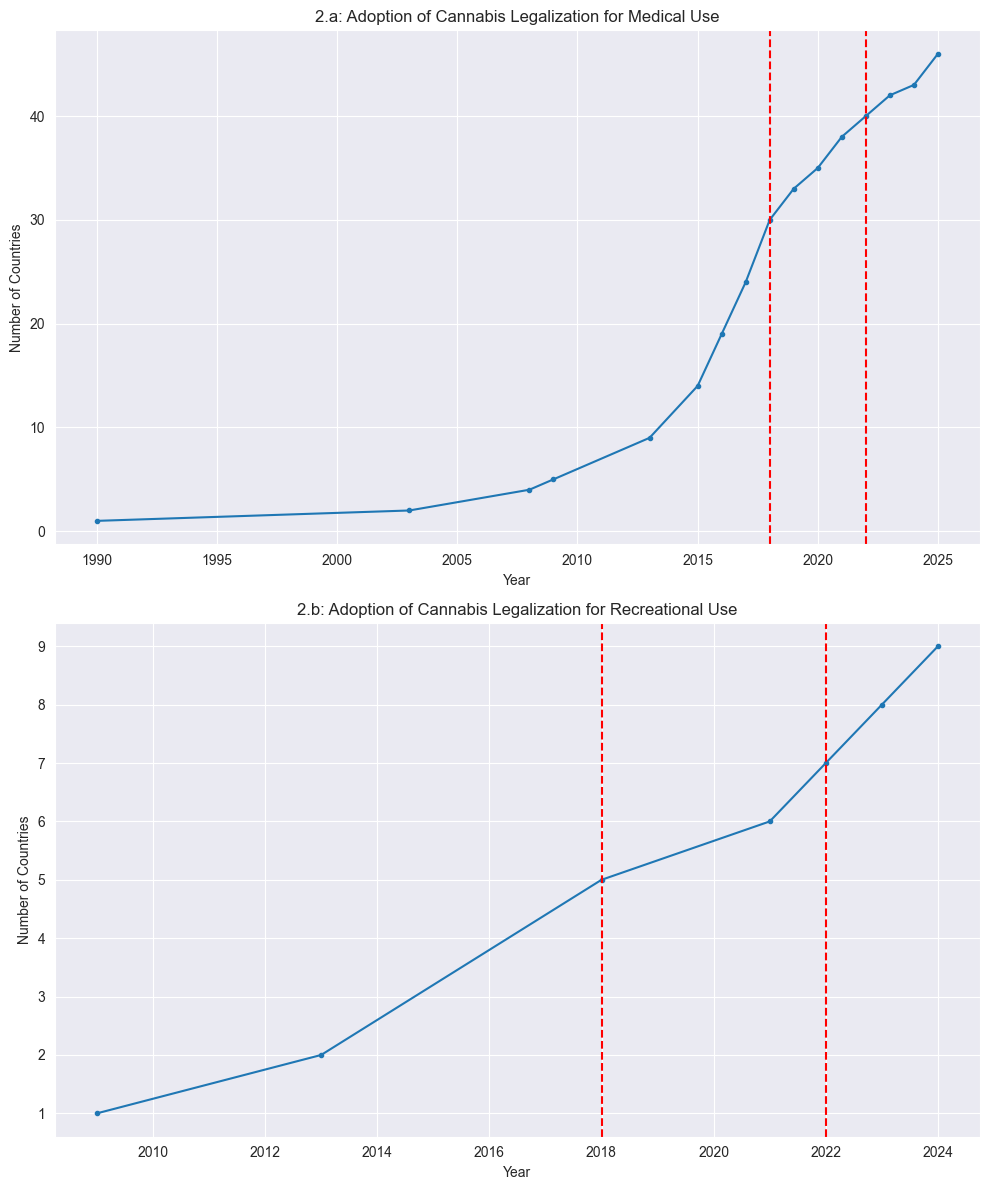

In [15]:
# Filter for medical use legalization and count cumulative sum
med_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'MED'].groupby('medical_year').size().sort_index().cumsum()

# Filter for recreational use legalization and count cumulative sum
rec_adoption = legalization_df_sorted[legalization_df_sorted['legal_category'] == 'LGL'].groupby('recreational_year').size().sort_index().cumsum()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 2.a: Medical Use Legalization
ax1.plot(med_adoption.index, med_adoption.values, marker='o', linestyle='-', markersize=3)
ax1.axvline(x=2018, color='r', linestyle='--')
ax1.axvline(x=2022, color='r', linestyle='--')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Countries')
ax1.set_title('2.a: Adoption of Cannabis Legalization for Medical Use')
ax1.grid(True)

# Subplot 2.b: Recreational Use Legalization
ax2.plot(rec_adoption.index, rec_adoption.values, marker='o', linestyle='-', markersize=3)
ax2.axvline(x=2018, color='r', linestyle='--')
ax2.axvline(x=2022, color='r', linestyle='--')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Countries')
ax2.set_title('2.b: Adoption of Cannabis Legalization for Recreational Use')
ax2.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Key points

1) From figure 2.a - we can see that in 2022, there we overall 40 countries that have legalized cannabis for medical uses, 10 of them had been added between 2018-2022 - making them prominent candidates test our hypothesis.
2) From figure 2.b, we infer that we don't have many cases of countries that enacted full legalization of cannabis, having only **9** total countries in 2024. Furthermore, between 2018 and 2022, there was only one country - Malta, that adopted these laws. We do however, see that in 2018 - **3** countries have legalized cannabis for all purposes, so if we could expand the seizure data, we could add these countries to our analysis as well.

---

#### 4.2.3 - Analyzing possession limits distribution for countries with decriminalization policies
We speculate that the distribution might help us find a trend in policy adoption.
Alternatively, help us understand the trends in drug trafficking seizures and criminal arrests incidents.

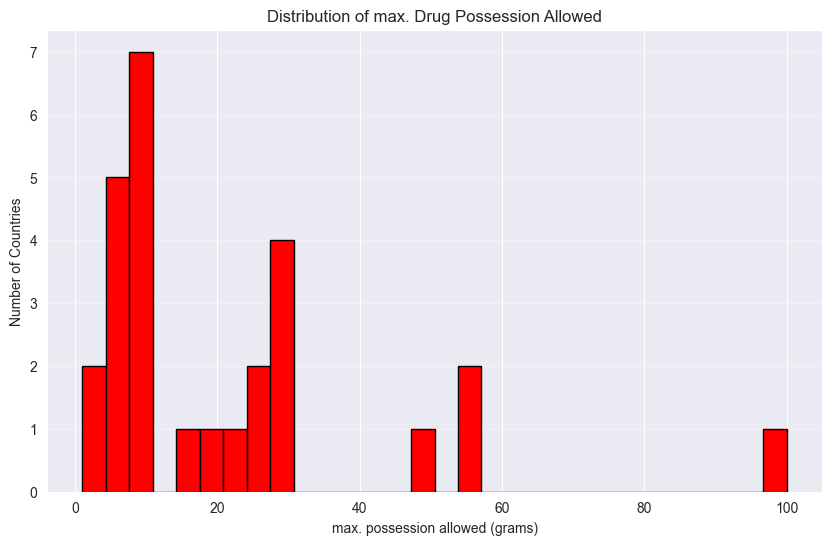

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(legalization_df['Decriminalized_max_possession'].dropna(), bins=30, color='red', edgecolor='black')
plt.xlabel('max. possession allowed (grams)')
plt.ylabel('Number of Countries')
plt.title('Distribution of max. Drug Possession Allowed')
plt.grid(axis='y', alpha=0.35)

#### Key Notes:
As it could be seen above, most countries consider a 30 gram amount of cannabis possession as a non-criminal offense. This could help us explain the sudden shift in seizures found in [figure 1.b](#figure-1b) for cannabis

---

### 4.3 - *wbg_pop_health_gdp* dataset

This dataset contains demographic data that will act as input features for the models and as normalization factors - $VPC_{year}=Z_{year}/p_{year}$ where:
- $VPC_{year}$: value per capita for a country in some year.
- $Z_{year}$: any numerical variable, for example *seizure_volume*.
- $p_{year}$: The country's population given in the given year.

#### 4.3.1 - overview features

Let us look again at the raw data we have exported:


In [17]:
demographics_df.sample(10)

,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024],Unnamed: 12,Unnamed: 13
697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,Japan,JPN,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,10.65627098,10.73988247,10.96998405,11.20903683,11.18996906,11.42183685,..,..,NaN,NaN
227,Gibraltar,GIB,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,..,..,..,..,..,..,..,..,NaN,NaN
336,Liberia,LBR,"Population, total",SP.POP.TOTL,4848925,4944726,5043721,5149463,5259323,5373294,5493031,..,NaN,NaN
537,Spain,ESP,"Population, total",SP.POP.TOTL,46593236,46797754,47134837,47365655,47415794,47759127,48347910,..,NaN,NaN
793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,Fiji,FJI,"Population, total",SP.POP.TOTL,918759,917180,914899,914963,916711,919422,924145,..,NaN,NaN
247,Guinea-Bissau,GNB,GDP (current US$),NY.GDP.MKTP.CD,1469978606,1554133594,1588638854,1646400350,1853796456,1796608531,2048348108,..,NaN,NaN
448,Pakistan,PAK,GDP (current US$),NY.GDP.MKTP.CD,3.39206E+11,3.56128E+11,3.20909E+11,3.00426E+11,3.48517E+11,3.7489E+11,3.37912E+11,..,NaN,NaN
572,Tajikistan,TJK,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,6.85399008,7.01381588,6.9476676,8.8903532,8.37504482,7.62917423,..,..,NaN,NaN


We can see that currently the features we intended to use: Population, GDP and health expenditure are under the *Series Name* feature and the value per year for each year is a variable of its own.<br>
We'd like to pivot the dataframe so that each value in *Series Name* become a column and the years will become rows, which means each country that is currently represented with one row will be represented independently for each year - i.e. each country will be represented by 8 rows instead.<BR>
Firstly, we will need to handle `..` values, that probably act as null values - so we will turn them into `None` values.<BR><BR>
#### 4.3.2 - handle null values

In [18]:
demographics_df_edited = demographics_df.replace("..", np.nan)

# drop rows that only contain null values
demographics_df_edited = demographics_df_edited.dropna(how='all', axis=0)

print("demographics_df dimensions:", demographics_df_edited.shape)
demographics_df_edited.sample(10)

demographics_df dimensions: (640, 14)


C:\Users\aries\AppData\Local\Temp\ipykernel_17396\1724646822.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  demographics_df_edited = demographics_df.replace("..", np.nan)


,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024],Unnamed: 12,Unnamed: 13
123,China,CHN,"Population, total",SP.POP.TOTL,1396215000,1402760000,1407745000,1411100000,1412360000,1412175000,1410710000,NaN,NaN,NaN
207,French Polynesia,PYF,"Population, total",SP.POP.TOTL,280087,279815,279034,279209,279792,280378,281118,NaN,NaN,NaN
462,Peru,PER,"Population, total",SP.POP.TOTL,31324637,31897584,32449303,32838579,33155882,33475438,33845617,NaN,NaN,NaN
351,"Macao SAR, China",MAC,"Population, total",SP.POP.TOTL,648400,658900,672000,685400,682500,677300,678800,NaN,NaN,NaN
159,Denmark,DNK,"Population, total",SP.POP.TOTL,5764980,5793636,5814422,5831404,5856733,5903037,5946952,NaN,NaN,NaN
541,Sri Lanka,LKA,GDP (current US$),NY.GDP.MKTP.CD,94376237797,94493871201,89014978344,84304298771,88609324902,74144870023,84356863744,NaN,NaN,NaN
501,Senegal,SEN,"Population, total",SP.POP.TOTL,15475002,15914498,16352922,16789219,17220867,17651103,18077573,NaN,NaN,NaN
527,Solomon Islands,SLB,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,4.16556406,3.86440825,4.43728065,4.89478445,4.94758463,4.82369328,NaN,NaN,NaN,NaN
70,Bolivia,BOL,GDP (current US$),NY.GDP.MKTP.CD,37508642165,40287647930,40895322844,36629843805,40406111695,44008282878,45135398009,NaN,NaN,NaN
554,St. Vincent and the Grenadines,VCT,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,4.22985649,4.25346231,4.25543451,4.8395834,5.36252117,4.68767738,NaN,NaN,NaN,NaN


In [19]:
print(f"{'~'*10} {demographics_df_edited.columns[-1]} {'~'*10}", demographics_df_edited[demographics_df_edited.columns[-1]].value_counts(dropna=False))
print(f"{'~'*10} {demographics_df_edited.columns[-2]} {'~'*10}", demographics_df_edited[demographics_df_edited.columns[-2]].value_counts(dropna=False))


~~~~~~~~~~ Unnamed: 13 ~~~~~~~~~~ Unnamed: 13
NaN                                                        636
https://datacatalog.worldbank.org/public-licenses#cc-by      3
License URL                                                  1
Name: count, dtype: int64
~~~~~~~~~~ Unnamed: 12 ~~~~~~~~~~ Unnamed: 12
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       638
Notes from original source                                                                                                             

Now we will also remove columns that are unnecessary for our analysis:
- Series code: an alias for the variables found at *Series Name*
- The last two columns contain notes about the dataset, as you can see above. They don't contain any additional information.

We'll also remove the [YRXXXX] suffix from the year's columns are groundwork for the pivot table and dataset merging stages.<BR>
In addition, we will also change the values of our variables of interest to more programmatically-friendly format.

In [20]:
demographics_df_edited = demographics_df_edited.rename(columns={
    "2017 [YR2017]": "2017",
    "2018 [YR2018]": "2018",
    "2019 [YR2019]": "2019",
    "2020 [YR2020]": "2020",
    "2021 [YR2021]": "2021",
    "2022 [YR2022]": "2022",
    "2023 [YR2023]": "2023",
    "2024 [YR2024]": "2024",
    "Country Name": "country",
    
})
dem_df_cols = demographics_df_edited.columns.tolist()
dem_df_cols.remove('Series Code')
dem_df_cols = dem_df_cols[:-2]
demographics_df_edited = demographics_df_edited[dem_df_cols]

demographics_df_edited["Series Name"] = demographics_df_edited["Series Name"].replace({
    "GDP (current US$)": "gdp",
    "Population, total": "population",
    "Current health expenditure (% of GDP)": "health_expenditure"
})

demographics_df_edited.sample(10)

,country,Country Code,Series Name,2017,2018,2019,2020,2021,2022,2023,2024
622,Uruguay,URY,gdp,65006039995,65344576348,62222325807,53668636568,60760798596,70164683290,77240830877,NaN
534,South Sudan,SSD,population,10259154,10122977,10423384,10698467,10865780,11021177,11483374,NaN
188,Estonia,EST,health_expenditure,6.59727049,6.6912818,6.81699181,7.57906437,7.47860336,6.98701143,NaN,NaN
307,Kiribati,KIR,gdp,222875724.7,233514703.7,216985362.3,223123620.6,289339292.2,270841698.4,279208903.3,NaN
360,Malaysia,MYS,population,32355644,32910967,33440596,33889558,34282399,34695493,35126298,NaN
531,South Africa,ZAF,population,57635162,58613001,59587885,60562381,61502603,62378410,63212384,NaN
251,Guyana,GUY,health_expenditure,4.3191123,4.90492535,4.90331507,5.4180727,4.92369986,3.00636959,NaN,NaN
240,Guatemala,GTM,population,16567357,16845685,17103803,17357325,17598650,17847877,18124838,NaN
199,Fiji,FJI,gdp,5353469171,5581425325,5444407214,4432466237,4305031631,4969503561,5442046565,NaN
478,Qatar,QAT,gdp,1.61099E+11,1.83335E+11,1.76371E+11,1.44411E+11,1.79732E+11,2.35709E+11,2.13003E+11,NaN


#### 4.3.3 - pivot table and introduce *year* feature

We'd like to pivot the dataframe so'd the column for each year will become a single variable called *year*, that'll indicate the recording year the data. We'd also want to create for each value of *Series Name* its own variable.

(disclaimer - Gemini helped us tackle the errors we got when we tried to pivot the table)

In [21]:
melted_demographics_df = demographics_df_edited.melt(id_vars=['country', 'Country Code', 'Series Name'],
                                                     var_name='year',
                                                     value_name='value')

melted_demographics_df['year'] = melted_demographics_df['year'].astype(int)
melted_demographics_df['value'] = pd.to_numeric(melted_demographics_df['value'], errors='coerce')

pivoted_demographics_df = melted_demographics_df.pivot_table(index=['country', 'Country Code', 'year'],
                                                             columns='Series Name',
                                                             values='value')

pivoted_demographics_df = pivoted_demographics_df.reset_index()

pivoted_demographics_df.sample(10)

Series Name,country,Country Code,year,gdp,health_expenditure,population
391,Dominica,DMA,2023,6.539926e+08,NaN,66510.0
1066,Papua New Guinea,PNG,2019,2.475063e+10,2.325339,9609010.0
488,French Polynesia,PYF,2022,5.814661e+09,NaN,280378.0
917,Mongolia,MNG,2017,1.148085e+10,4.339542,3148917.0
1154,San Marino,SMR,2023,NaN,NaN,33860.0
976,Netherlands,NLD,2020,9.325610e+11,11.223557,17441500.0
1324,Syrian Arab Republic,SYR,2018,2.149778e+10,3.866130,19577845.0
694,Jordan,JOR,2018,4.337086e+10,6.982950,10462306.0
851,Maldives,MDV,2021,5.252457e+09,10.096117,516154.0
32,Andorra,AND,2021,3.324648e+09,8.334507,78364.0


Let's also add a GDP per capita column - to normalize the logarithmic scale of GDP:

In [22]:
pivoted_demographics_df['gdp_per_capita'] = pivoted_demographics_df['gdp'] / pivoted_demographics_df['population']

#### 4.3.4 - EDA for each variable:
Firstly let's examine the relationship between *GDP* and *health expenditure*, on average over the years, and see if richer countries put more effort into healthcare for their civilians:

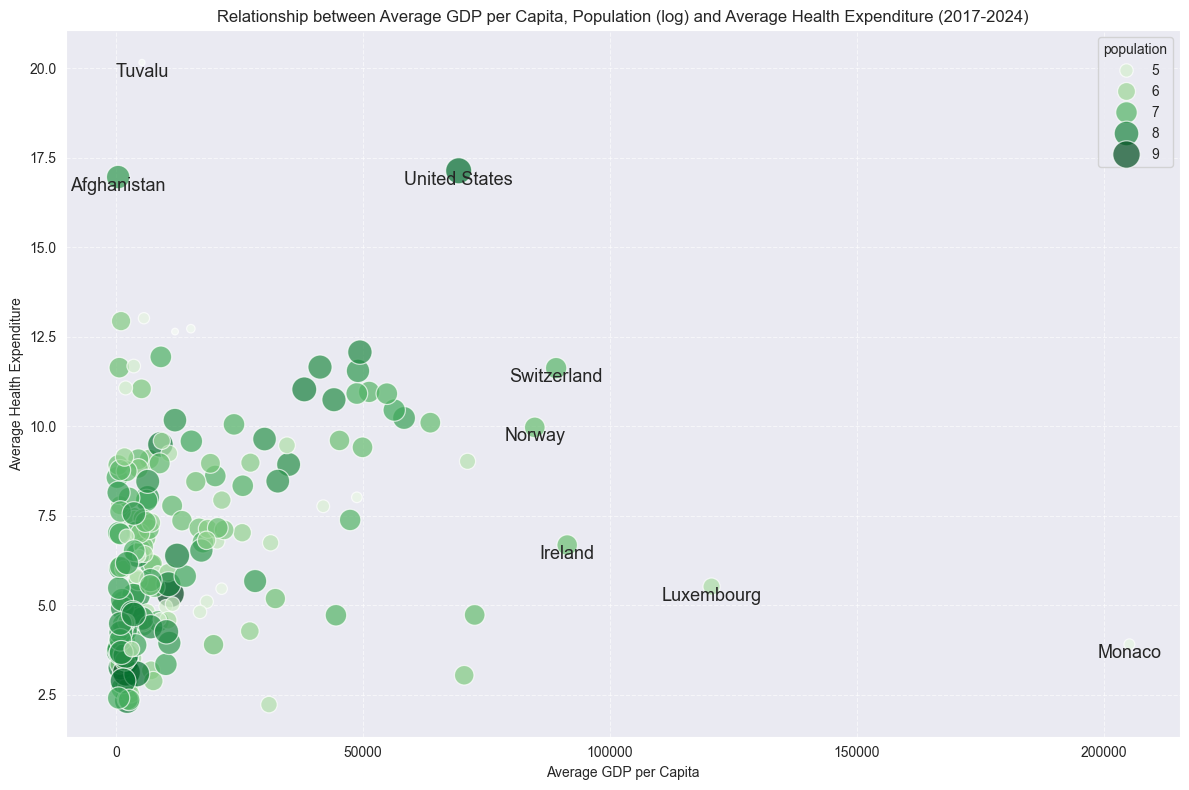

In [23]:
# Group by country and country code and calculate the mean of gdp_per_capita, health_expenditure, and population
df_averaged = pivoted_demographics_df.groupby(['country', 'Country Code'])[['gdp_per_capita', 'health_expenditure', 'population']].mean().reset_index()

# Apply log transformation to population, handling potential zero or negative values if any
df_averaged['population'] = np.log10(df_averaged['population'].replace(0, np.nan)) # Replace 0 with NaN to avoid log(0)

# Filter out rows with NaN values in 'gdp_per_capita' or 'health_expenditure' for plotting
df_plot_averaged = df_averaged.dropna(subset=['gdp_per_capita', 'health_expenditure'])


# Identify outlier points based on the specified criteria
outliers = df_plot_averaged[(df_plot_averaged['health_expenditure'] > 15) | (df_plot_averaged['gdp_per_capita'] > 75000)]

# Create the scatter plot for the averaged data, colored by average population
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_plot_averaged,
                x='gdp_per_capita',
                y='health_expenditure',
                hue='population', # Color by average population
                size='population', # Use size for population as well to add more visual weight
                sizes=(20, 400), # Adjust min/max size of markers
                palette='Greens', # Choose a suitable palette for population
                alpha=0.7)

plt.title('Relationship between Average GDP per Capita, Population (log) and Average Health Expenditure (2017-2024)')
plt.xlabel('Average GDP per Capita')
plt.ylabel('Average Health Expenditure')
plt.grid(True, linestyle='--', alpha=0.6)

# Label the outlier points
for i, row in outliers.iterrows():
    plt.text(row['gdp_per_capita'], row['health_expenditure'], row['country'],
             fontsize=13, ha='center', va='top')

plt.tight_layout()
plt.show()

It is unclear from the scatterplot above if the three variables have correlation between them, but there is some interesting insights:
- Most countries with a small GDP per capita have different healthcare budgets, so we can't say that low-income countries necessarily spend less on healthcare.
- Countries with high GDP per capita do not spend more on healthcare than "poorer" countries - see Ireland vs. Afghanistan for example.
- Population is not really a factor for health budget. However, there seems to be some relationship between it and GDP per capita (except some outlying values like the US) - The larger the country (in terms of population) the less each person is budgeted, and vice versa.

Let's try to infer some information using Spearman's correlation:<BR>
$\rho = 1 - \frac{6\sum_{i=1}^{n} d_i^2}{n(n^2-1)}$
<BR>
*We use Spearman since the data is not normally distributed, as we see above.


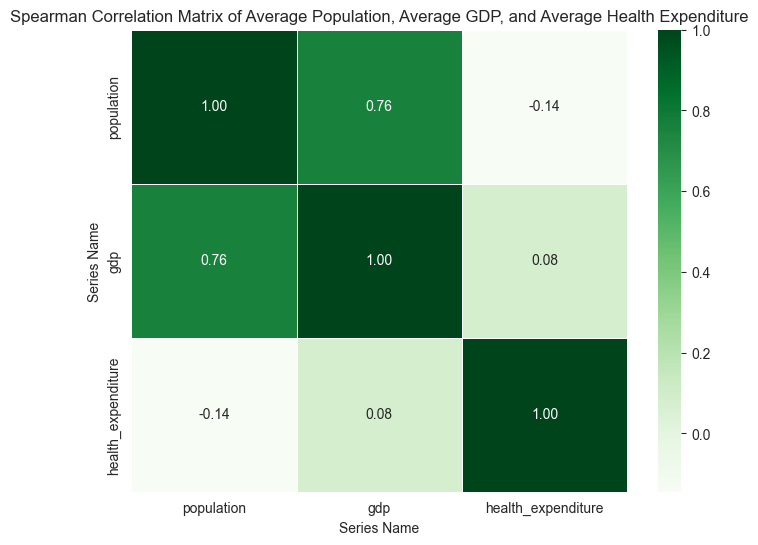

In [24]:
# Group by country and country code and calculate the mean of gdp, health_expenditure, and population
# This time we are using original gdp and population, not per capita or log scale
df_averaged_for_corr = pivoted_demographics_df.groupby(['country', 'Country Code'])[['gdp', 'health_expenditure', 'population']].mean().reset_index()

# Drop rows with NaN values in any of the three relevant columns for correlation matrix
df_plot_correlation_matrix = df_averaged_for_corr.dropna(subset=['gdp', 'health_expenditure', 'population'])

# Calculate the correlation matrix
correlation_matrix = df_plot_correlation_matrix[['population', 'gdp', 'health_expenditure']].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=.5)
plt.title('Spearman Correlation Matrix of Average Population, Average GDP, and Average Health Expenditure')
plt.show()

As we can see from the correlation matrix above, there's a high correlation between *population* and *GDP*, which suggest that we should use the population as a normalization feature but not include it as an input to our models, since at least on variable might reliably replace it.

---

### 4.4 - *unodc_drug_crime_counts* dataset

In this dataset, we can extract the number of incidents of trafficking and possession of illicit drugs per country and for each year between 2018-2022. Furthermore, it also provides additional drill-downs into drug-types and different subgroups in the population - differentiating between male and female culprits, and also taking into account juveniles.
  In this section we will clean and re-order the data, and provide some analyses on the subgroups mentioned above.

#### 4.4.1 - overview features
Let us firstly take another look at the raw data as it was provided by UNODC

In [25]:
crime_counts_df.columns

Index(['Region', 'SubRegion', 'Country', 'campaign', 'Year', 'Type of offence',
       'Drug', 'Calculated total', 'Reported total', 'Males', 'Females',
       'Adults', 'Juveniles', 'Unknown/Other/ Third/Intersex',
       'Specify year if other', 'Adults: 18 and older',
       'Juveniles: under 18 years old', 'msCode'],
      dtype='object')

In [26]:
crime_counts_df.sample(10, random_state=SEED)

,Region,SubRegion,Country,campaign,Year,Type of offence,Drug,Calculated total,Reported total,Males,Females,Adults,Juveniles,Unknown/Other/ Third/Intersex,Specify year if other,Adults: 18 and older,Juveniles: under 18 years old,msCode
1079,Europe,Western and Central Europe,Greece,ARQ2020,2020,Offences related to drug trafficking,Any Illicit drugs,3347,3347.0,2819.0,298.0,3289.0,58.0,230.0,NaN,Yes,Yes,GRC
405,Europe,Eastern Europe,Republic of Moldova,ARQ2022,2022,Other drug-related offences,Any Illicit drugs,102,102.0,88.0,14.0,100.0,2.0,NaN,NaN,Yes,Yes,MDA
1493,Oceania,Australia and New Zealand,Australia,HIST2019,2019,Offences related to drug use and/or drug posse...,Cannabis-type,48431,39492.0,39758.0,8673.0,NaN,NaN,NaN,NaN,NaN,Yes,AUS
239,Oceania,Australia and New Zealand,New Zealand,HIST2018,2018,Offences related to drug trafficking,Hallucinogens,28,28.0,24.0,4.0,NaN,NaN,NaN,NaN,NaN,Yes,NZL
610,Americas,South America,Paraguay,ARQ2020,2020,Offences related to drug trafficking,Any Illicit drugs,337,337.0,274.0,63.0,293.0,11.0,NaN,NaN,Yes,Yes,PRY
99,Americas,South America,Bolivia (Plurinational State of),ARQ2021,2021,Other drug-related offences,Any Illicit drugs,6,6.0,5.0,0.0,6.0,0.0,1.0,NaN,Yes,Yes,BOL
1145,Americas,North America,Mexico,HIST2018,2018,Offences related to drug trafficking,Cannabis-type,4869,4869.0,4568.0,301.0,NaN,NaN,NaN,NaN,NaN,Yes,MEX
297,Americas,South America,Ecuador,HIST2019,2019,Offences related to drug trafficking,Cannabis-type,50,50.0,46.0,4.0,NaN,NaN,NaN,NaN,NaN,Yes,ECU
932,Americas,South America,Uruguay,HIST2018,2018,Offences related to drug trafficking,Cannabis-type,1607,1607.0,1260.0,347.0,NaN,NaN,NaN,NaN,NaN,NaN,URY
275,Africa,East Africa,Mauritius,HIST2018,2018,Offences related to drug trafficking,Sedatives and tranquillizers,41,41.0,40.0,1.0,NaN,NaN,NaN,NaN,NaN,Yes,MUS


In terms of relevant variables, we see the following as the values of interest:
- *Country* (will be changed to `country`): our main way to merge the datasets. Also is a part of what we define a population by.
- *Year* (will be changed to `year`): The 2nd part of the definition of a population. An integral part of our temporal analysis.
- *Drug* (will be changed to `drug_group`): Is the counterpart of `drug_name` in the seizures dataset, will be part of our analysis and later dismissed when we merge the above datasets together (as it'll be taken from the *seizures* dataset).
- *Type of offence* (will be changed to `offence_type`): differentiates between possession for use by a single too few person use (`Offences related to drug use and/or drug possession`) and more major volume of drugs possession - for sale, production or trafficking (`Offences related to drug trafficking`). The first might correlate to the treatment data, and the other to the seizures' data. We will demonstrate their behaviour across regions, gender and years. There is also a `Other drug-related offences` value that we'll have to see whether it could be ignored.
-  *Males*, *Females*, *Adults*, *Juveniles* and *Unknown...*: These are the variables that indicate the annual amount of incidents for a drug in a country. When summed together, they're represented by the *Calculated total* variable. We will see whether it is necessary to keep these values separated or they won't provide any useful information, and we'll use the aggregated version (by looking at the amount of null values for example). Additionally, when we'll merge the datasets into a singular dataframe, the values will be normalized by the country's population for that year, and will become *incidents per capita*.



In contrast - the following variables will be lightly used or not used at all:
- *Region* and *SubRegion*: Is the exact same as in the seizure dataset, we will use these variables for analysis, but then it'll be dismissed as we'll use the previous dataset's values.
- *campaign*: This is another way to represent the year.
- *Reported total*: This aggregated variable does not align as the sum of other variables, which raises the question we do they define a 'reported' incident. We prefer to aggregate the variables mentioned above ourselves, therefore we see no use for this column.
- *specify year if other*: This column probably tries to align with camping and does not have much non-null values anyway.
- *Adults 18 and older* and *Juveniles under 18...*: these binary values indicate the definitions of a juvenile for each country, but we will try to be agnostic to this definition.
- *msCode*: a country's symbol. We'll use `country` instead.


In [27]:
edited_crime_counts_df = crime_counts_df.rename(columns={
    "Country": "country",
    "Region": "region",
    "Year": "year",
    "SubRegion": "sub_region",
    "Type of offence": "offence_type",
    "Drug": "drug_group",
    "Males": "males_cases",
    "Females": "females_cases",
    "Adults": "adults_cases",
    "Juveniles": "juveniles_cases",
    "Unknown/Other/ Third/Intersex": "other_cases"
})
edited_crime_counts_df = edited_crime_counts_df[["region", "sub_region", "country", "year", "offence_type", "drug_group", "males_cases", "females_cases", "adults_cases", "juveniles_cases", "other_cases"]]

edited_crime_counts_df['region'] = edited_crime_counts_df.apply(lambda x: x['sub_region'] if "America" in x["sub_region"] else x["region"], axis=1)
edited_crime_counts_df['region'] = edited_crime_counts_df.apply(lambda x: "Central America" if "Americas" in x["region"] else x["region"], axis=1)

edited_crime_counts_df.sample(10, random_state=SEED)

,region,sub_region,country,year,offence_type,drug_group,males_cases,females_cases,adults_cases,juveniles_cases,other_cases
1079,Europe,Western and Central Europe,Greece,2020,Offences related to drug trafficking,Any Illicit drugs,2819.0,298.0,3289.0,58.0,230.0
405,Europe,Eastern Europe,Republic of Moldova,2022,Other drug-related offences,Any Illicit drugs,88.0,14.0,100.0,2.0,NaN
1493,Oceania,Australia and New Zealand,Australia,2019,Offences related to drug use and/or drug posse...,Cannabis-type,39758.0,8673.0,NaN,NaN,NaN
239,Oceania,Australia and New Zealand,New Zealand,2018,Offences related to drug trafficking,Hallucinogens,24.0,4.0,NaN,NaN,NaN
610,South America,South America,Paraguay,2020,Offences related to drug trafficking,Any Illicit drugs,274.0,63.0,293.0,11.0,NaN
99,South America,South America,Bolivia (Plurinational State of),2021,Other drug-related offences,Any Illicit drugs,5.0,0.0,6.0,0.0,1.0
1145,North America,North America,Mexico,2018,Offences related to drug trafficking,Cannabis-type,4568.0,301.0,NaN,NaN,NaN
297,South America,South America,Ecuador,2019,Offences related to drug trafficking,Cannabis-type,46.0,4.0,NaN,NaN,NaN
932,South America,South America,Uruguay,2018,Offences related to drug trafficking,Cannabis-type,1260.0,347.0,NaN,NaN,NaN
275,Africa,East Africa,Mauritius,2018,Offences related to drug trafficking,Sedatives and tranquillizers,40.0,1.0,NaN,NaN,NaN


#### 4.4.2 - Trafficking vs. Possession cases

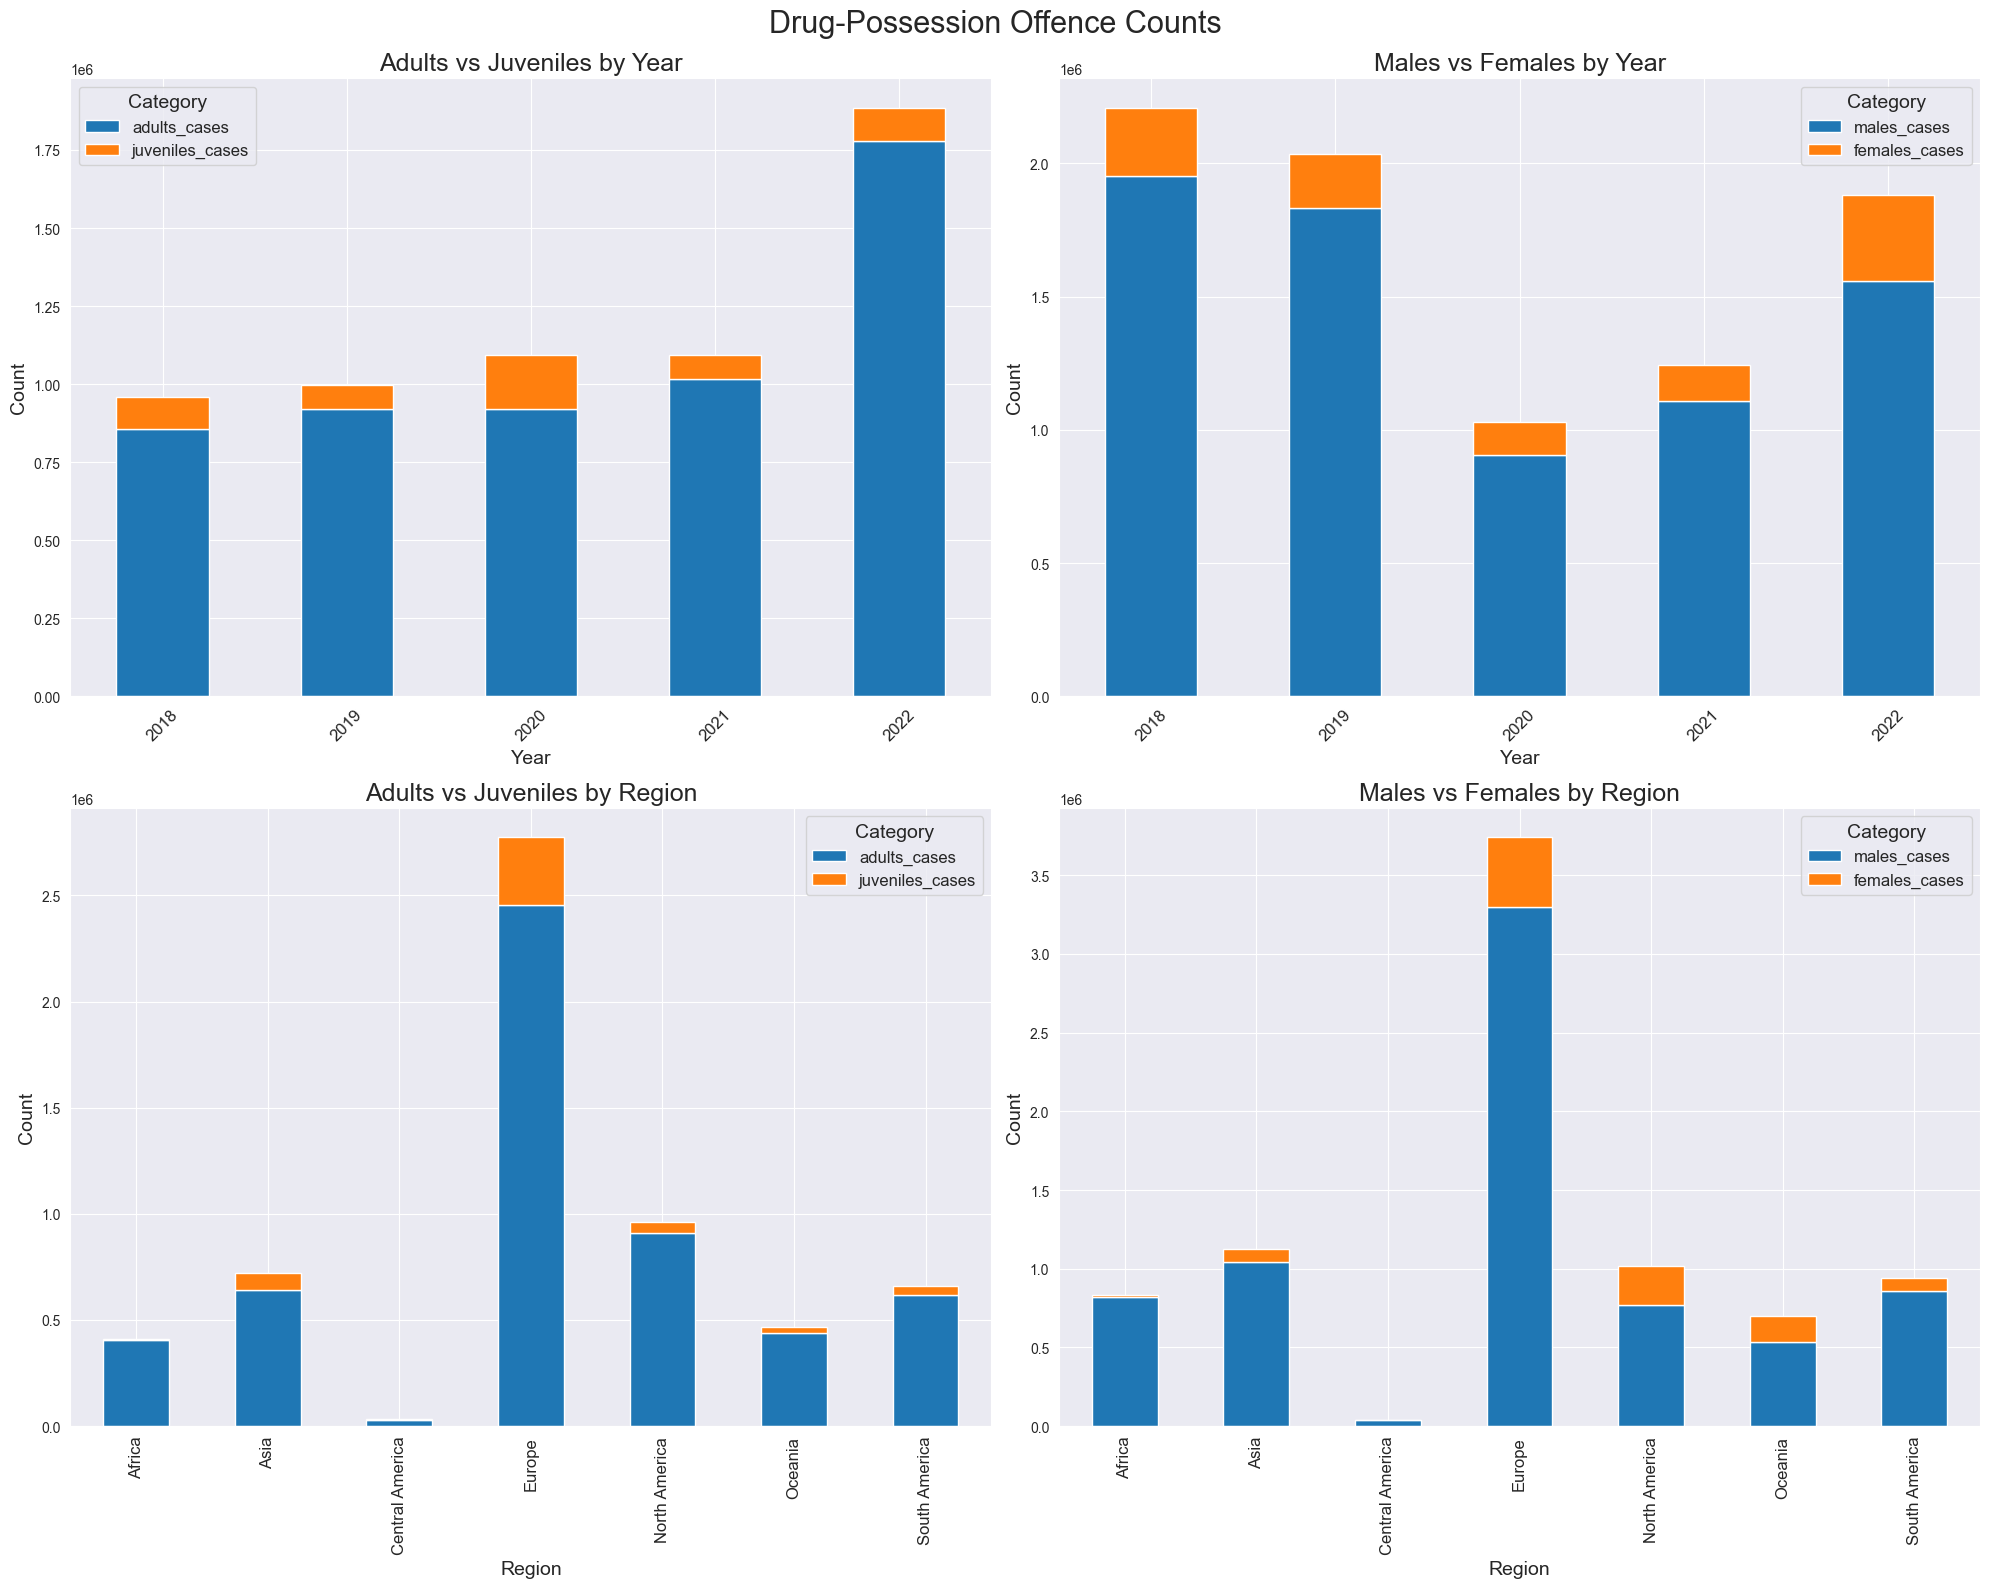

In [28]:
# Convert relevant columns to numeric, coercing errors
# Using the correct column names identified in the previous step
for col in ['males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'year']:
    edited_crime_counts_df[col] = pd.to_numeric(edited_crime_counts_df[col], errors='coerce')

# Filter for the specific offence type
drug_offences_df = edited_crime_counts_df[edited_crime_counts_df['offence_type'] == 'Offences related to drug use and/or drug possession']

# Prepare data for subplots

# Subplot 1 & 2: Aggregated by year
agg_year_adult_juvenile = drug_offences_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_year_male_female = drug_offences_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

# Subplot 3 & 4: Aggregated by region
agg_region_adult_juvenile = drug_offences_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_region_male_female = drug_offences_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

# Create the four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Drug-Possession Offence Counts', y=0.99, fontsize=22)

ax1, ax2, ax3, ax4 = axes.flatten()

# Subplot 1: Adults vs Juveniles by Year
agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Adults vs Juveniles by Year', fontsize=18)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 2: Males vs Females by Year
agg_year_male_female.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Males vs Females by Year', fontsize=18)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('Year', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 3: Adults vs Juveniles by Region
agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_title('Adults vs Juveniles by Region', fontsize=18)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_xlabel('Region', fontsize=14)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 4: Males vs Females by Region
agg_region_male_female.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_title('Males vs Females by Region', fontsize=18)
ax4.set_ylabel('Count', fontsize=14)
ax4.set_xlabel('Region', fontsize=14)
ax4.tick_params(axis='x', rotation=90, labelsize=12)
ax4.legend(title='Category', fontsize=12, title_fontsize=14)

plt.tight_layout() # Adjust layout to prevent title overlap
plt.show()

Now the same for drug trafficking:

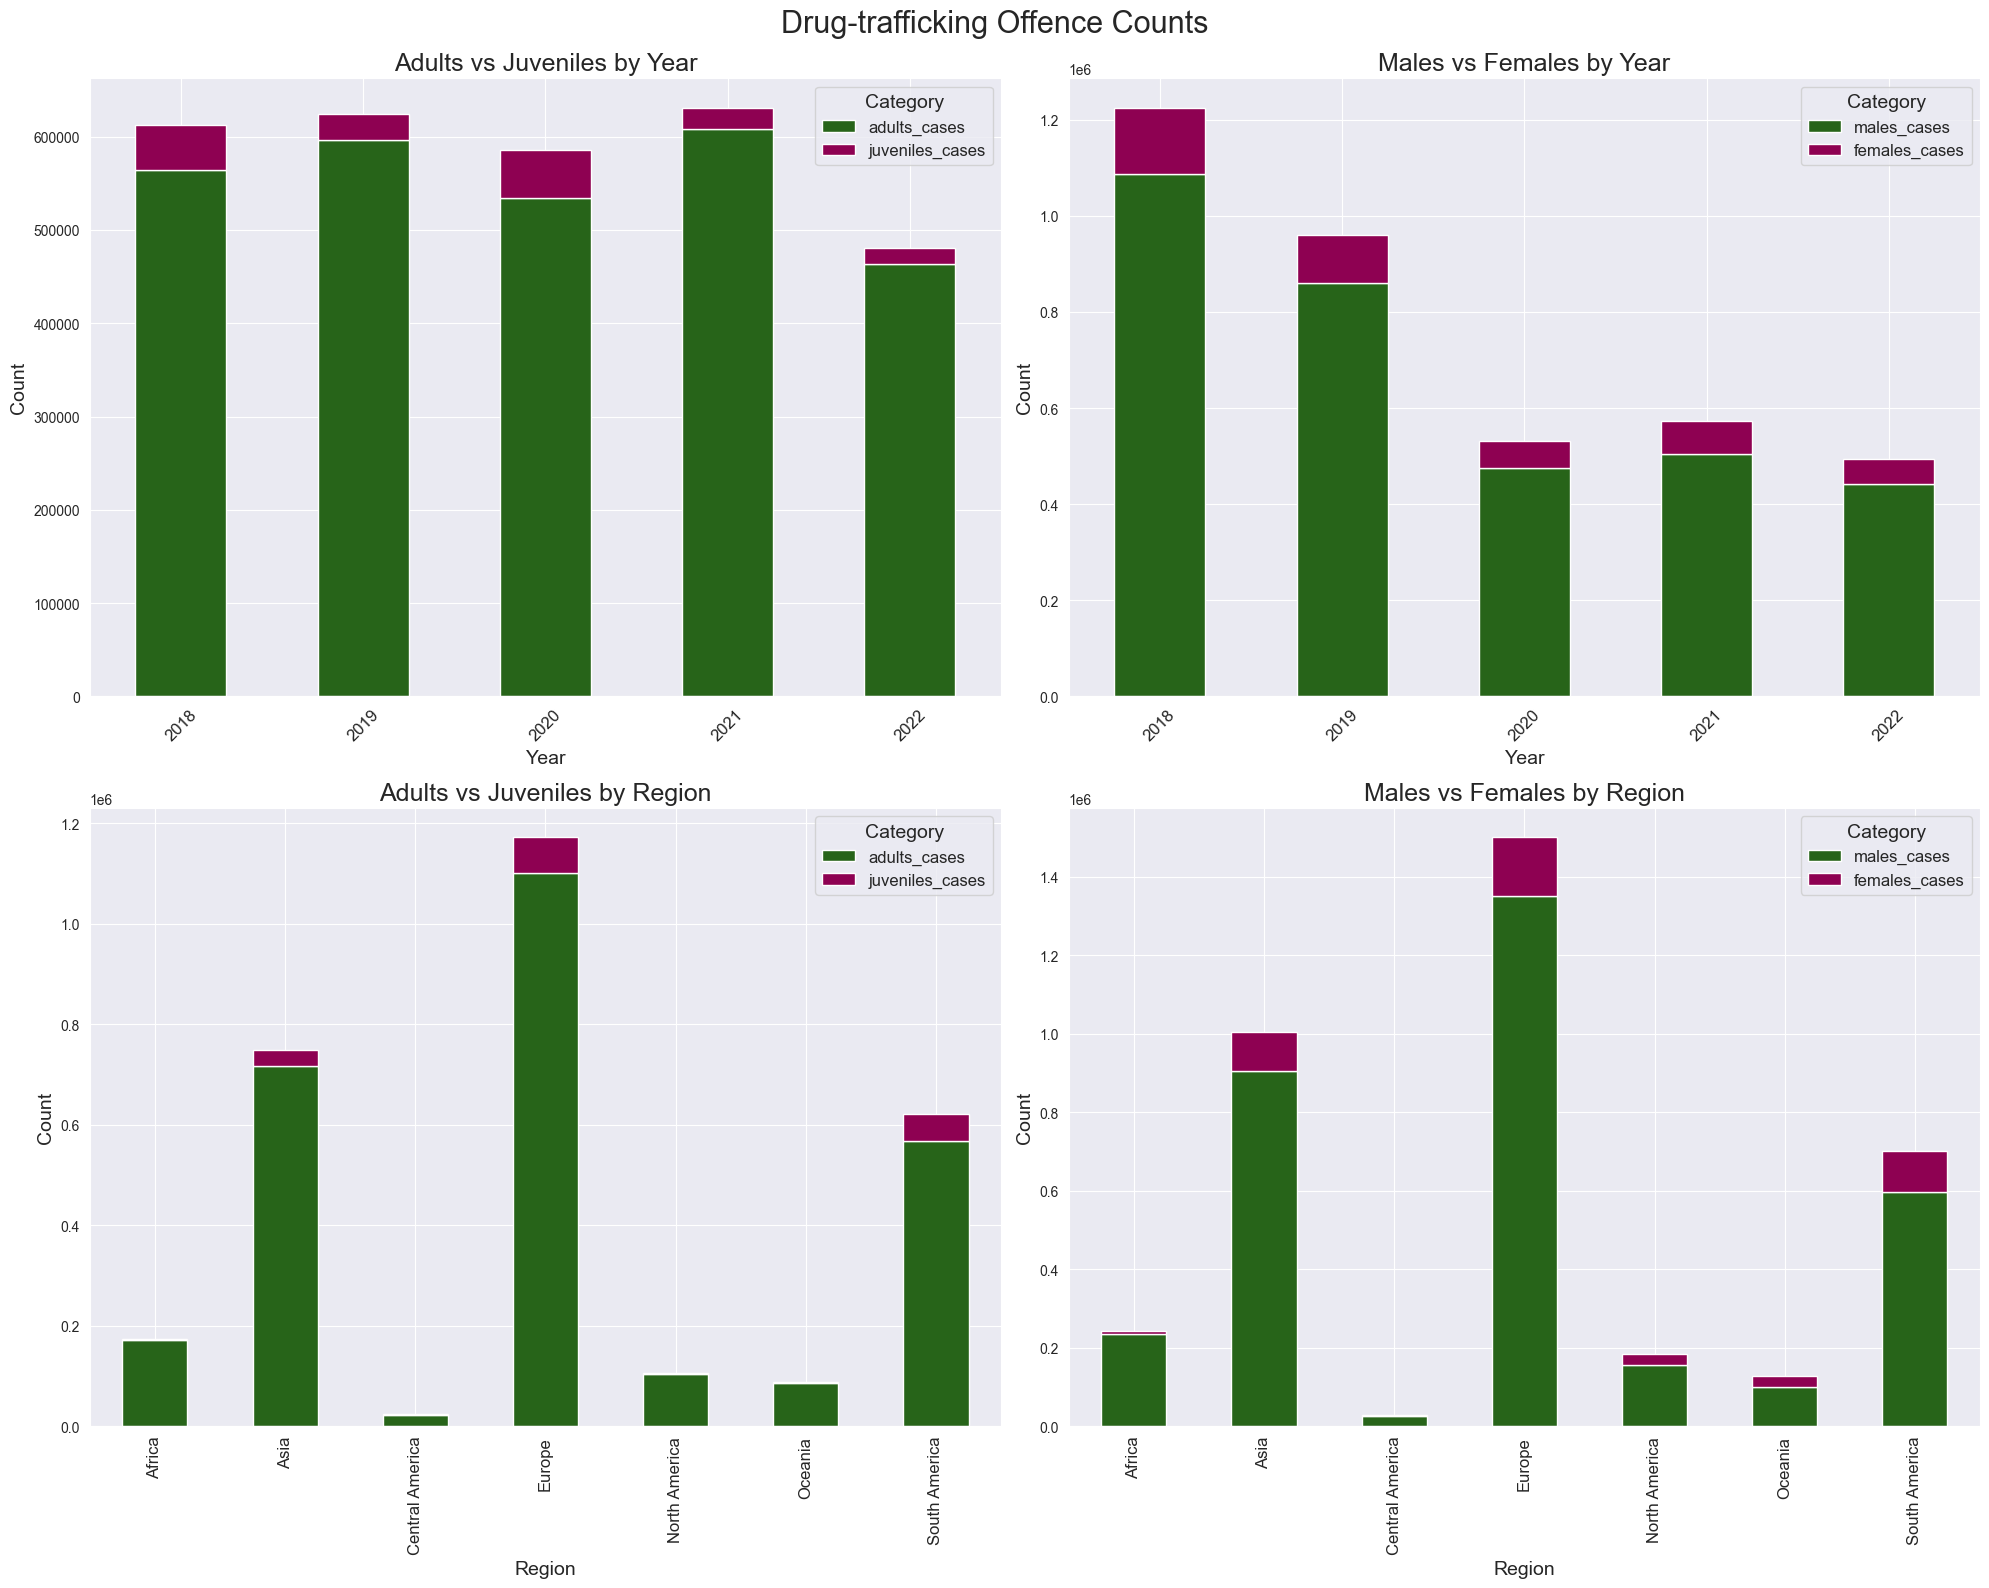

In [29]:
# Filter for the specific offence type
drug_offences_df = edited_crime_counts_df[edited_crime_counts_df['offence_type'] == 'Offences related to drug trafficking']

# Prepare data for subplots

# Subplot 1 & 2: Aggregated by year
agg_year_adult_juvenile = drug_offences_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_year_male_female = drug_offences_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

# Subplot 3 & 4: Aggregated by region
agg_region_adult_juvenile = drug_offences_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
agg_region_male_female = drug_offences_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

# Create the four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Drug-trafficking Offence Counts', y=0.99, fontsize=22)

ax1, ax2, ax3, ax4 = axes.flatten()

# Subplot 1: Adults vs Juveniles by Year
agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax1, cmap='PiYG_r')
ax1.set_title('Adults vs Juveniles by Year', fontsize=18)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 2: Males vs Females by Year
agg_year_male_female.plot(kind='bar', stacked=True, ax=ax2, cmap='PiYG_r')
ax2.set_title('Males vs Females by Year', fontsize=18)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('Year', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 3: Adults vs Juveniles by Region
agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax3, cmap='PiYG_r')
ax3.set_title('Adults vs Juveniles by Region', fontsize=18)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_xlabel('Region', fontsize=14)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.legend(title='Category', fontsize=12, title_fontsize=14)

# Subplot 4: Males vs Females by Region
agg_region_male_female.plot(kind='bar', stacked=True, ax=ax4, cmap='PiYG_r')
ax4.set_title('Males vs Females by Region', fontsize=18)
ax4.set_ylabel('Count', fontsize=14)
ax4.set_xlabel('Region', fontsize=14)
ax4.tick_params(axis='x', rotation=90, labelsize=12)
ax4.legend(title='Category', fontsize=12, title_fontsize=14)

plt.tight_layout() # Adjust layout to prevent title overlap
plt.show()

|And finally for different drug types:

In [30]:
drug_offences_df['drug_group'].unique()

array(['Other opioids not under international control',
       'Any Illicit drugs', 'Opioids', 'Hallucinogens', 'ATS',
       'Other substances not under int. control', 'Plant-based NPS',
       'Other miscellaneous', 'Pharmaceutical opioids', 'Cocaine-type',
       'Ecstasy-type substances', 'Other Plant-based substances',
       'Non-specified', 'Non-specified substances not under int. control',
       'GBL', 'Cannabis-type', 'Methamphetamine', 'Benzodiazepines',
       'Multiple Drugs', 'Other stimulants',
       'Sedatives and tranquillizers',
       'Ketamine and phencyclidine-type substances', 'Crack', 'Heroin',
       'GHB', 'Other types of cannabis', 'Other NPS',
       'Coca paste/cocaine base', 'Marijuana (herb)', 'Hashish (resin)'],
      dtype=object)

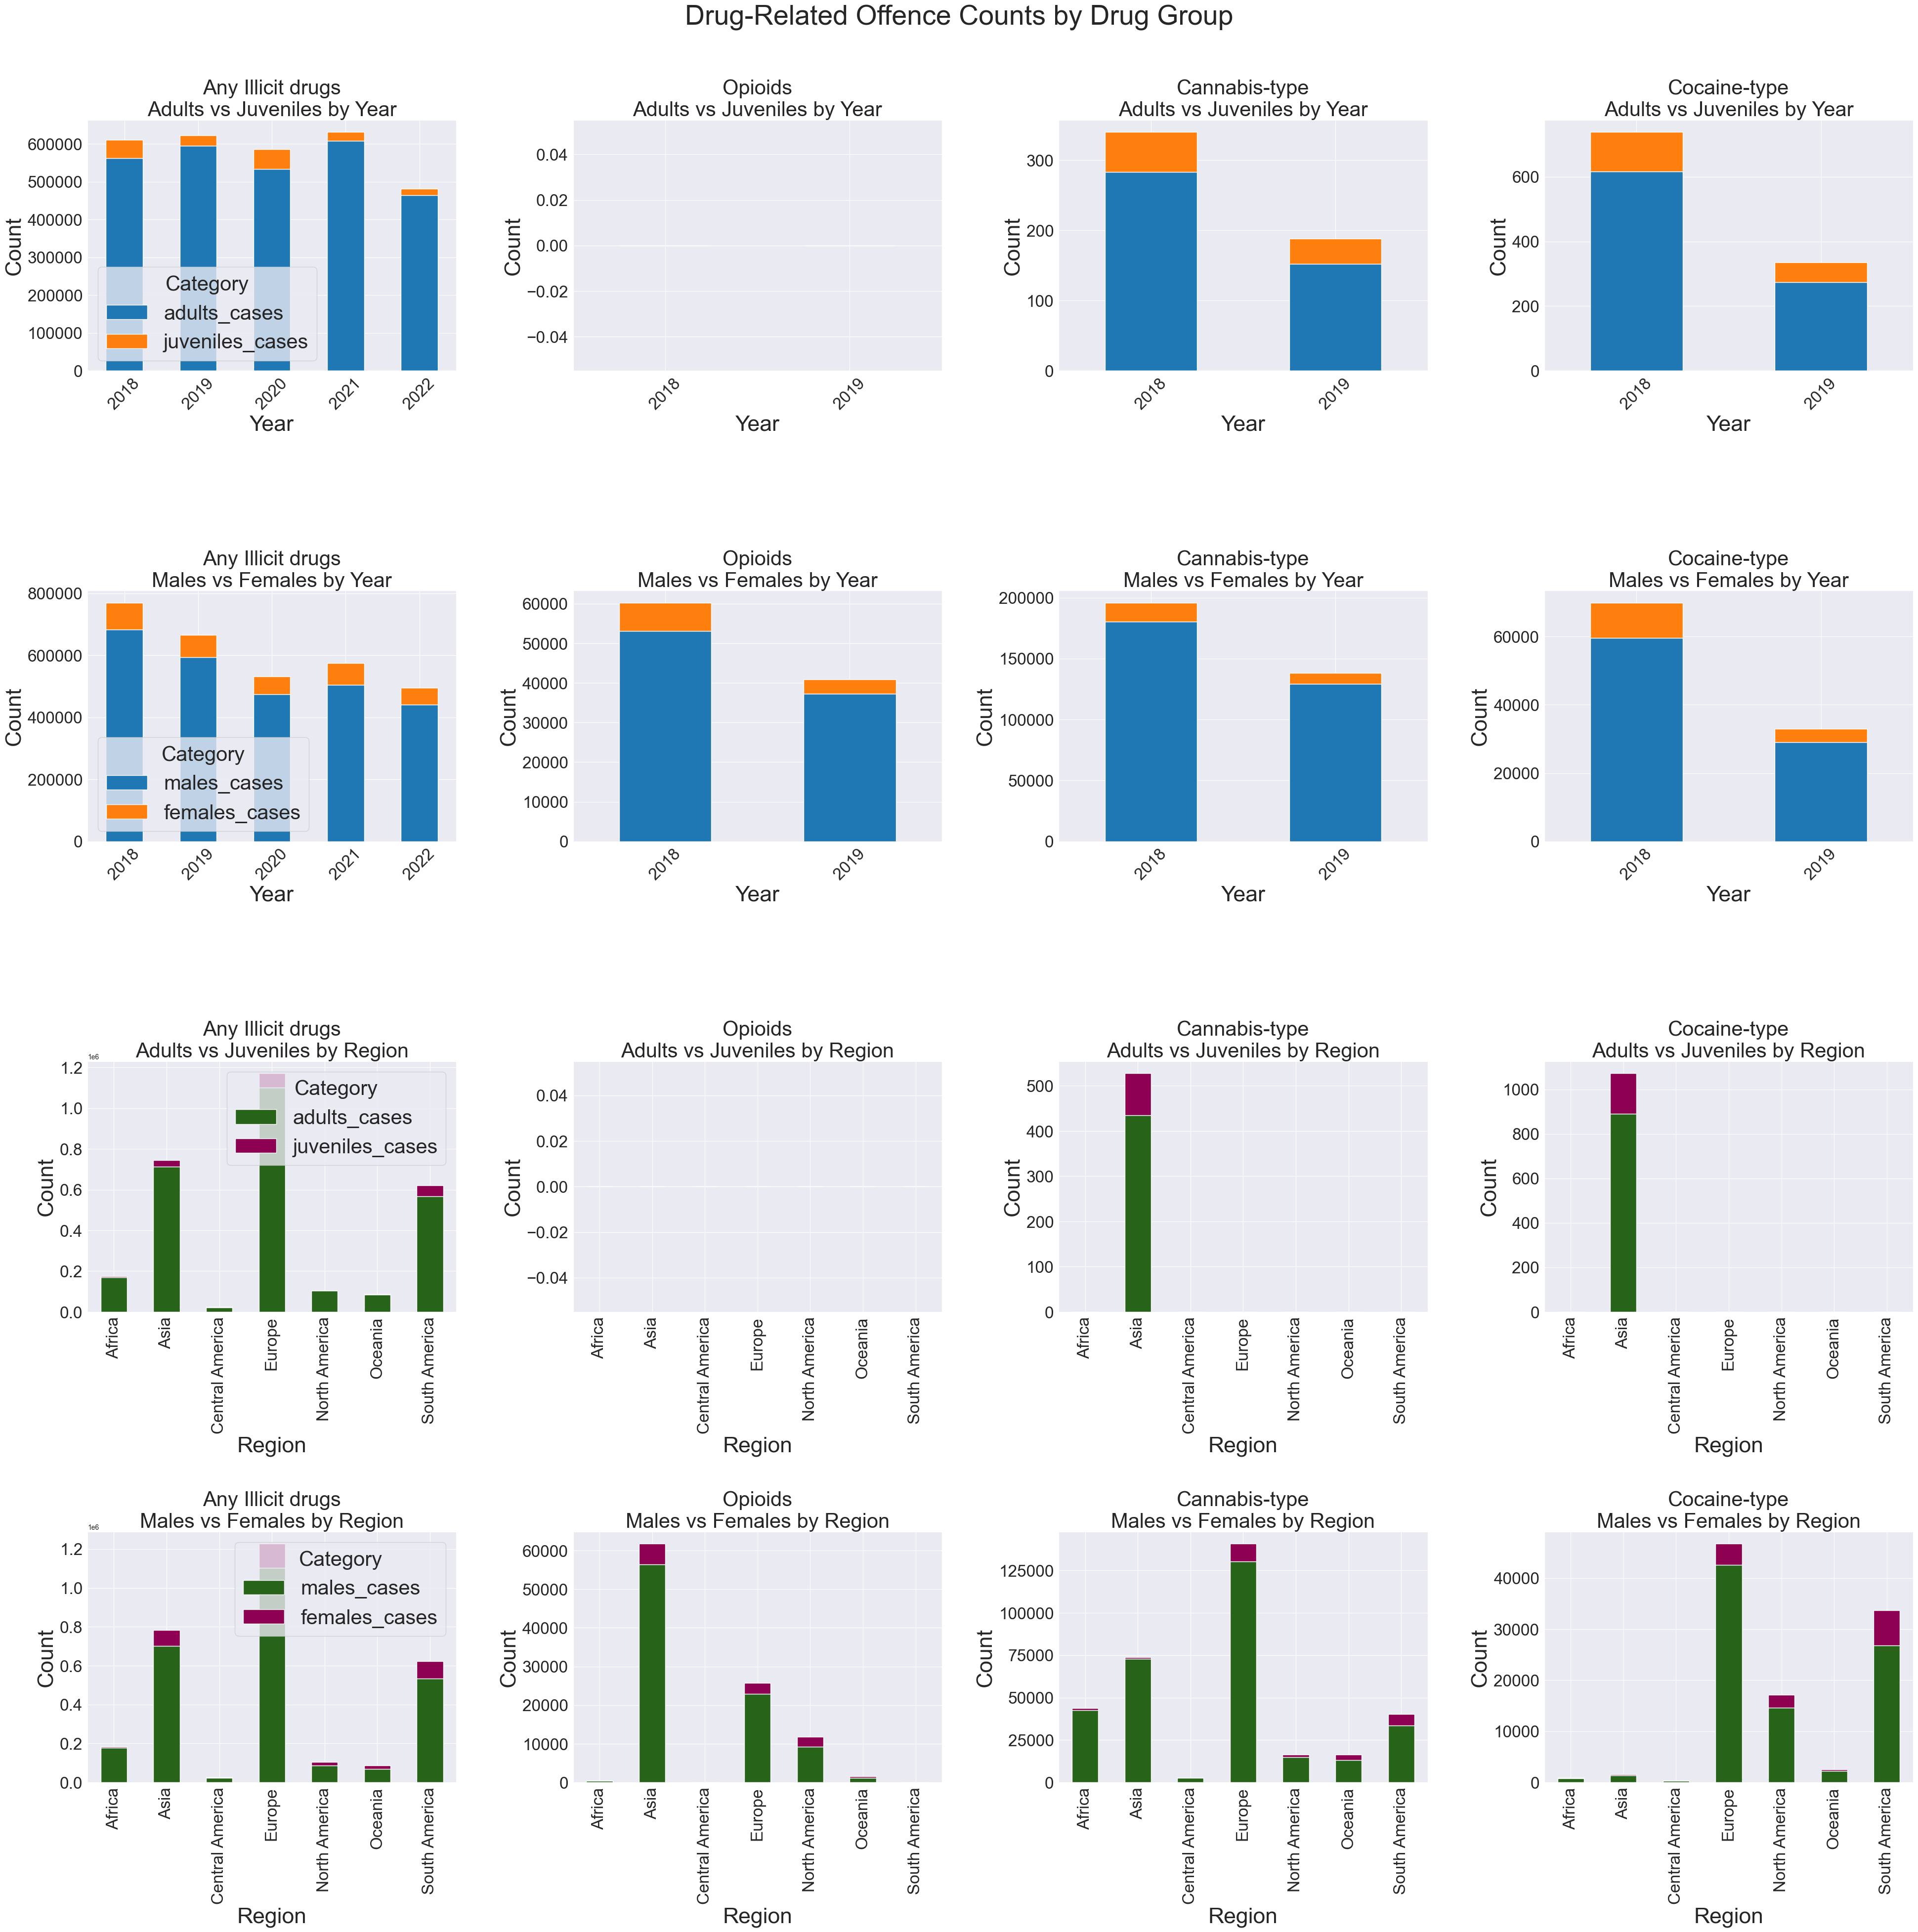

In [31]:
# Get unique drug groups
selected_drug_groups = ['Any Illicit drugs', 'Opioids', 'Cannabis-type', 'Cocaine-type']
num_drug_groups = len(selected_drug_groups)

# Create a figure with 4 rows and N columns (N = number of drug groups)
fig, axes = plt.subplots(4, num_drug_groups, figsize=(40, 40)) # Adjust figsize as needed
fig.suptitle('Drug-Related Offence Counts by Drug Group', y=0.99, fontsize=40)

# Iterate through each drug group and create a column of plots
for col_idx, drug_group in enumerate(selected_drug_groups):
    # Filter data for the current drug group
    current_drug_group_df = drug_offences_df[drug_offences_df['drug_group'] == drug_group]

    # Prepare data for subplots for the current drug group

    # Aggregated by year
    agg_year_adult_juvenile = current_drug_group_df.groupby('year')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
    agg_year_male_female = current_drug_group_df.groupby('year')[['males_cases', 'females_cases']].sum().fillna(0)

    # Aggregated by region
    agg_region_adult_juvenile = current_drug_group_df.groupby('region')[['adults_cases', 'juveniles_cases']].sum().fillna(0)
    agg_region_male_female = current_drug_group_df.groupby('region')[['males_cases', 'females_cases']].sum().fillna(0)

    # Plotting for the current drug group column

    # Subplot Row 0: Adults vs Juveniles by Year
    ax0 = axes[0, col_idx] if num_drug_groups > 1 else axes[0]
    agg_year_adult_juvenile.plot(kind='bar', stacked=True, ax=ax0)
    ax0.set_title(f'{drug_group}\nAdults vs Juveniles by Year', fontsize=30)
    ax0.set_ylabel('Count', fontsize=32)
    ax0.set_xlabel('Year', fontsize=32)
    ax0.tick_params(axis='x', rotation=45, labelsize=24)
    ax0.tick_params(axis='y', labelsize=24)
    if col_idx == 0: # Only show legend for the first column to avoid redundancy
        ax0.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax0.legend().set_visible(False)


    # Subplot Row 1: Males vs Females by Year
    ax1 = axes[1, col_idx] if num_drug_groups > 1 else axes[1]
    agg_year_male_female.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title(f'{drug_group}\nMales vs Females by Year', fontsize=30)
    ax1.set_ylabel('Count', fontsize=32)
    ax1.set_xlabel('Year', fontsize=32)
    ax1.tick_params(axis='x', rotation=45, labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax1.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax1.legend().set_visible(False)

    # Subplot Row 2: Adults vs Juveniles by Region
    ax2 = axes[2, col_idx] if num_drug_groups > 1 else axes[2]
    agg_region_adult_juvenile.plot(kind='bar', stacked=True, ax=ax2, cmap='PiYG_r')
    ax2.set_title(f'{drug_group}\nAdults vs Juveniles by Region', fontsize=30)
    ax2.set_ylabel('Count', fontsize=32)
    ax2.set_xlabel('Region', fontsize=32)
    ax2.tick_params(axis='x', rotation=90, labelsize=24)
    ax2.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax2.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax2.legend().set_visible(False)

    # Subplot Row 3: Males vs Females by Region
    ax3 = axes[3, col_idx] if num_drug_groups > 1 else axes[3]
    agg_region_male_female.plot(kind='bar', stacked=True, ax=ax3, cmap='PiYG_r')
    ax3.set_title(f'{drug_group}\nMales vs Females by Region', fontsize=30)
    ax3.set_ylabel('Count', fontsize=32)
    ax3.set_xlabel('Region', fontsize=32)
    ax3.tick_params(axis='x', rotation=90, labelsize=24)
    ax3.tick_params(axis='y', labelsize=24)
    if col_idx == 0:
        ax3.legend(title='Category', fontsize=30, title_fontsize=30)
    else:
        ax3.legend().set_visible(False)
        
plt.tight_layout(pad=5)
plt.show()

From the three figures above we can infer the following:
- Females and juveniles are underrepresented. This could be for multiple reasons, but the main issue is that age and gender are not really factors, especially when there is a large bias and not a lot of recorded incidents (in the cases of adults vs. juveniles)
- The trends we saw in [section 4.1.3](#413---eda---exploring-_kilograms_---our-target-variable) about seizures of different drug types across different continents is also consistent in the last figure, with opioids being prevalent in Asia and Cocaine in Europe and the Americas. However, we see some missing information with some of the drug types and the age categories. Furthermore, much more concerning is that drug-type specific information, which only seem to exist in 2018 to 2019. This might limit our drug-type specific models.

As we see that we are missing data - we'd like to see the magnitude for each of the variables:

<Figure size 1000x600 with 0 Axes>

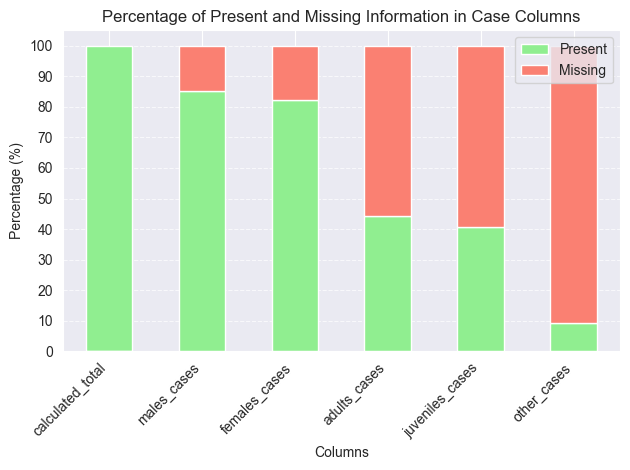

In [32]:
# Calculate the percentage of missing values for each column
nulls_df = edited_crime_counts_df[['males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'other_cases']].copy()
nulls_df["calculated_total"] = crime_counts_df["Calculated total"]
nulls_df = nulls_df[['calculated_total', 'males_cases', 'females_cases', 'adults_cases', 'juveniles_cases', 'other_cases']]
missing_percentage = (nulls_df.isnull().sum() / len(edited_crime_counts_df)) * 100

# Calculate the percentage of present values for each column
present_percentage = 100 - missing_percentage

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Present': present_percentage,
    'Missing': missing_percentage
})

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
plot_df.plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'])
plt.title('Percentage of Present and Missing Information in Case Columns')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 101, 10)) # Set y-ticks from 0 to 100 in steps of 10
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the Percentages we see above, we unfortunately cannot rely solely on the gender or age cases for aggregation, since probably not all countries had reported this information. Therefore, we consider the *calculated total* as the variable we choose as an input for the model.

In [33]:
edited_crime_counts_df["calculated_total"] = crime_counts_df["Calculated total"]
# remove all other numerical variable columns
edited_crime_counts_df = edited_crime_counts_df.drop(columns=['adults_cases', 'juveniles_cases', 'other_cases'])
edited_crime_counts_df["crime_count_gender_ratio"] = dputil.calc_ratio(edited_crime_counts_df["females_cases"], edited_crime_counts_df["males_cases"])
edited_crime_counts_df = edited_crime_counts_df.drop(columns=['females_cases', 'males_cases'])

---

### 4.5 *unodc_treatments* dataset

#### 4.5.1 - feature overview

In [34]:
treatments_df.sample(10,random_state=SEED)

,Region,SubRegion,Country,msCode,Reference year,DrugGroup,Drug,Sex,Value,Campaign,Coverage
10172,Europe,Western and Central Europe,Portugal,PRT,2019,Non-medical use of pharmaceutical sedatives an...,Benzodiazepines,Total,30,HIST2019,National
10322,Europe,Western and Central Europe,Slovakia,SVK,2021,Solvents and inhalants,Solvents and inhalants,Total,20,ARQ2021,NaN
9195,Europe,Western and Central Europe,Luxembourg,LUX,2018,Non-medical use of pharmaceutical sedatives an...,Benzodiazepines,Total,1,HIST2019,National
357,Africa,Southern Africa,South Africa,ZAF,2020,Cocaine-type drugs,"“Crack” cocaine, freebase cocaine",Males,118,ARQ2020,NaN
4352,Asia,East and South-East Asia,Singapore,SGP,2021,"Opioids, including opiates and synthetic opioids",Other pharmaceutical opioids,Total,1,ARQ2021,NaN
6810,Europe,Western and Central Europe,Belgium,BEL,2020,Cannabis-type drugs,Cannabis herb (marijuana),Males,474,ARQ2020,NaN
11740,Europe,Western and Central Europe,United Kingdom,GBR,2020,"Opioids, including opiates and synthetic opioids",Methadone,Females,470,ARQ2021,NaN
11639,Europe,Western and Central Europe,United Kingdom,GBR,2019,"Opioids, including opiates and synthetic opioids","Opioids, including opiates and synthetic opioids",Males,35923,ARQ2020,NaN
9455,Europe,Western and Central Europe,Norway,NOR,2020,Other drugs / psychoactive substances / pharma...,Other drugs / psychoactive substances / pharma...,Males,2031,ARQ2020,NaN
9792,Europe,Western and Central Europe,Poland,POL,2018,Cocaine-type drugs,Cocaine-type drugs,Total,173,HIST2019,National


In [35]:
edited_treatments_df = treatments_df.rename(columns={
    "Region": "region",
    "SubRegion": "sub_region",
    "Country": "country",
    "Reference year": "year",
    "DrugGroup": "drug_group",
    "Drug": "drug_sub_group",
    "Sex": "gender",
    "Value": "number_of_treatments"
})


edited_treatments_df['region'] = edited_treatments_df.apply(lambda x: x['sub_region'] if "America" in x["sub_region"] else x["region"], axis=1)
edited_treatments_df['region'] = edited_treatments_df.apply(lambda x: "Central America" if "Americas" in x["region"] else x["region"], axis=1)

# remove duplications
edited_treatments_df = edited_treatments_df.groupby(["region", "country", "year", "drug_group", "drug_sub_group", "gender"], as_index=False)["number_of_treatments"].sum()

#### 4.5.2 - EDA:
* 4.5.2.1 - [analysis of yearly counts of treatments by continent](#4521---analysis-of-yearly-counts-of-treatments-by-continent)
* 4.5.2.2 - [yearly trends by gender, in addition to null value counts per year and continent](#)
* 4.5.2.3 - [yearly treatment count by select drug types](#)

#### 4.5.2.1 - analysis of yearly counts of treatments by continent
Like in the *seizures* and *crime count* datasets, we'll try to see if there's correlation between the numbers and trends, especially in Europe.

In [36]:
region_data = edited_treatments_df.groupby(["region", "year"])["number_of_treatments"].sum()
region_data

region           year
Africa           2018       96342
                 2019       97997
                 2020      470821
                 2021     1926286
                 2022      240478
Asia             2018     1891463
                 2019      756479
                 2020      292089
                 2021      695135
                 2022     1260184
Central America  2018       40799
                 2019       40617
                 2020      443858
                 2021        6656
                 2022       11747
Europe           2018     1885357
                 2019     3686394
                 2020     3430917
                 2021     2647679
                 2022     1551714
North America    2018     2178787
                 2019     4911229
                 2020     9594448
                 2021    11795922
                 2022      711640
Oceania          2018       55710
                 2019      148588
                 2021      174283
                 2022     

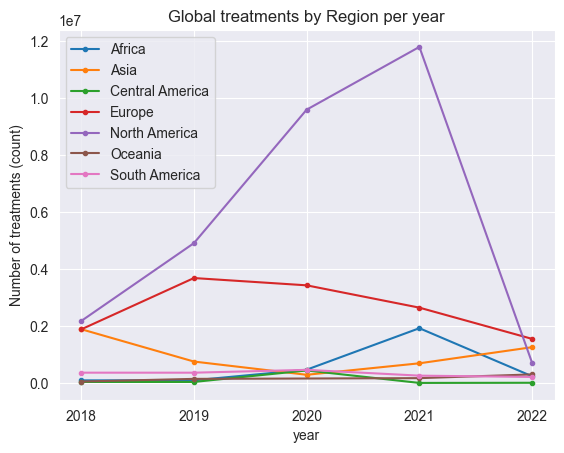

In [37]:
region_data = edited_treatments_df.groupby(["region", "year"], as_index=False)["number_of_treatments"].sum()

for region in region_data['region'].unique():
    region_specific_data = region_data[region_data["region"] == region]
    plt.plot(region_specific_data["year"], region_specific_data["number_of_treatments"], marker='o', linestyle='-', markersize=3, label=region)
plt.ylabel('Number of treatments (count)')
plt.xlabel('year')
plt.xticks(edited_treatments_df['year'].unique())
plt.title('Global treatments by Region per year')
plt.legend()
plt.show()

As we see from the figure above, we see an anomaly in N.America, with differences three times larger than other regions, then a sudden dip in 2022. We would like to see how the different countries' values change, in order to investigate this behaviour.

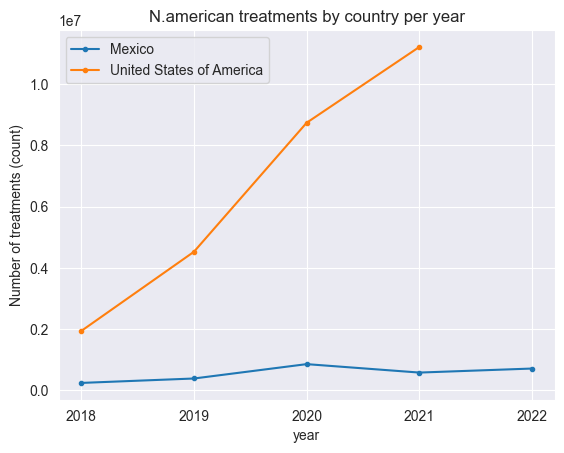

In [38]:
n_america_treatments = edited_treatments_df[edited_treatments_df["region"] == 'North America']
n_america_treatments = n_america_treatments.groupby(["country", "year"], as_index=False)["number_of_treatments"].sum()
n_america_countries = n_america_treatments['country'].unique()

for c in n_america_countries:
    data = n_america_treatments[n_america_treatments["country"] == c]
    plt.plot(data["year"], data["number_of_treatments"], marker='o', linestyle='-', markersize=3, label=c)
plt.ylabel('Number of treatments (count)')
plt.xlabel('year')
plt.xticks(edited_treatments_df['year'].unique())
plt.title('N.american treatments by country per year')
plt.legend()
plt.show()

As we can see, the reason for the low value in N.America came from the missing treatment value of the US. What is more interesting, is that we don't see values from *Canada*, which could be problematic because it's a country that is promoting legalization.

#### 4.5.2.2 - analysis of incidents by gender

Firstly, we'd like to check how many countries have reported gender-specific values for each year, to see whether we should factor it in our model's output instead of the total

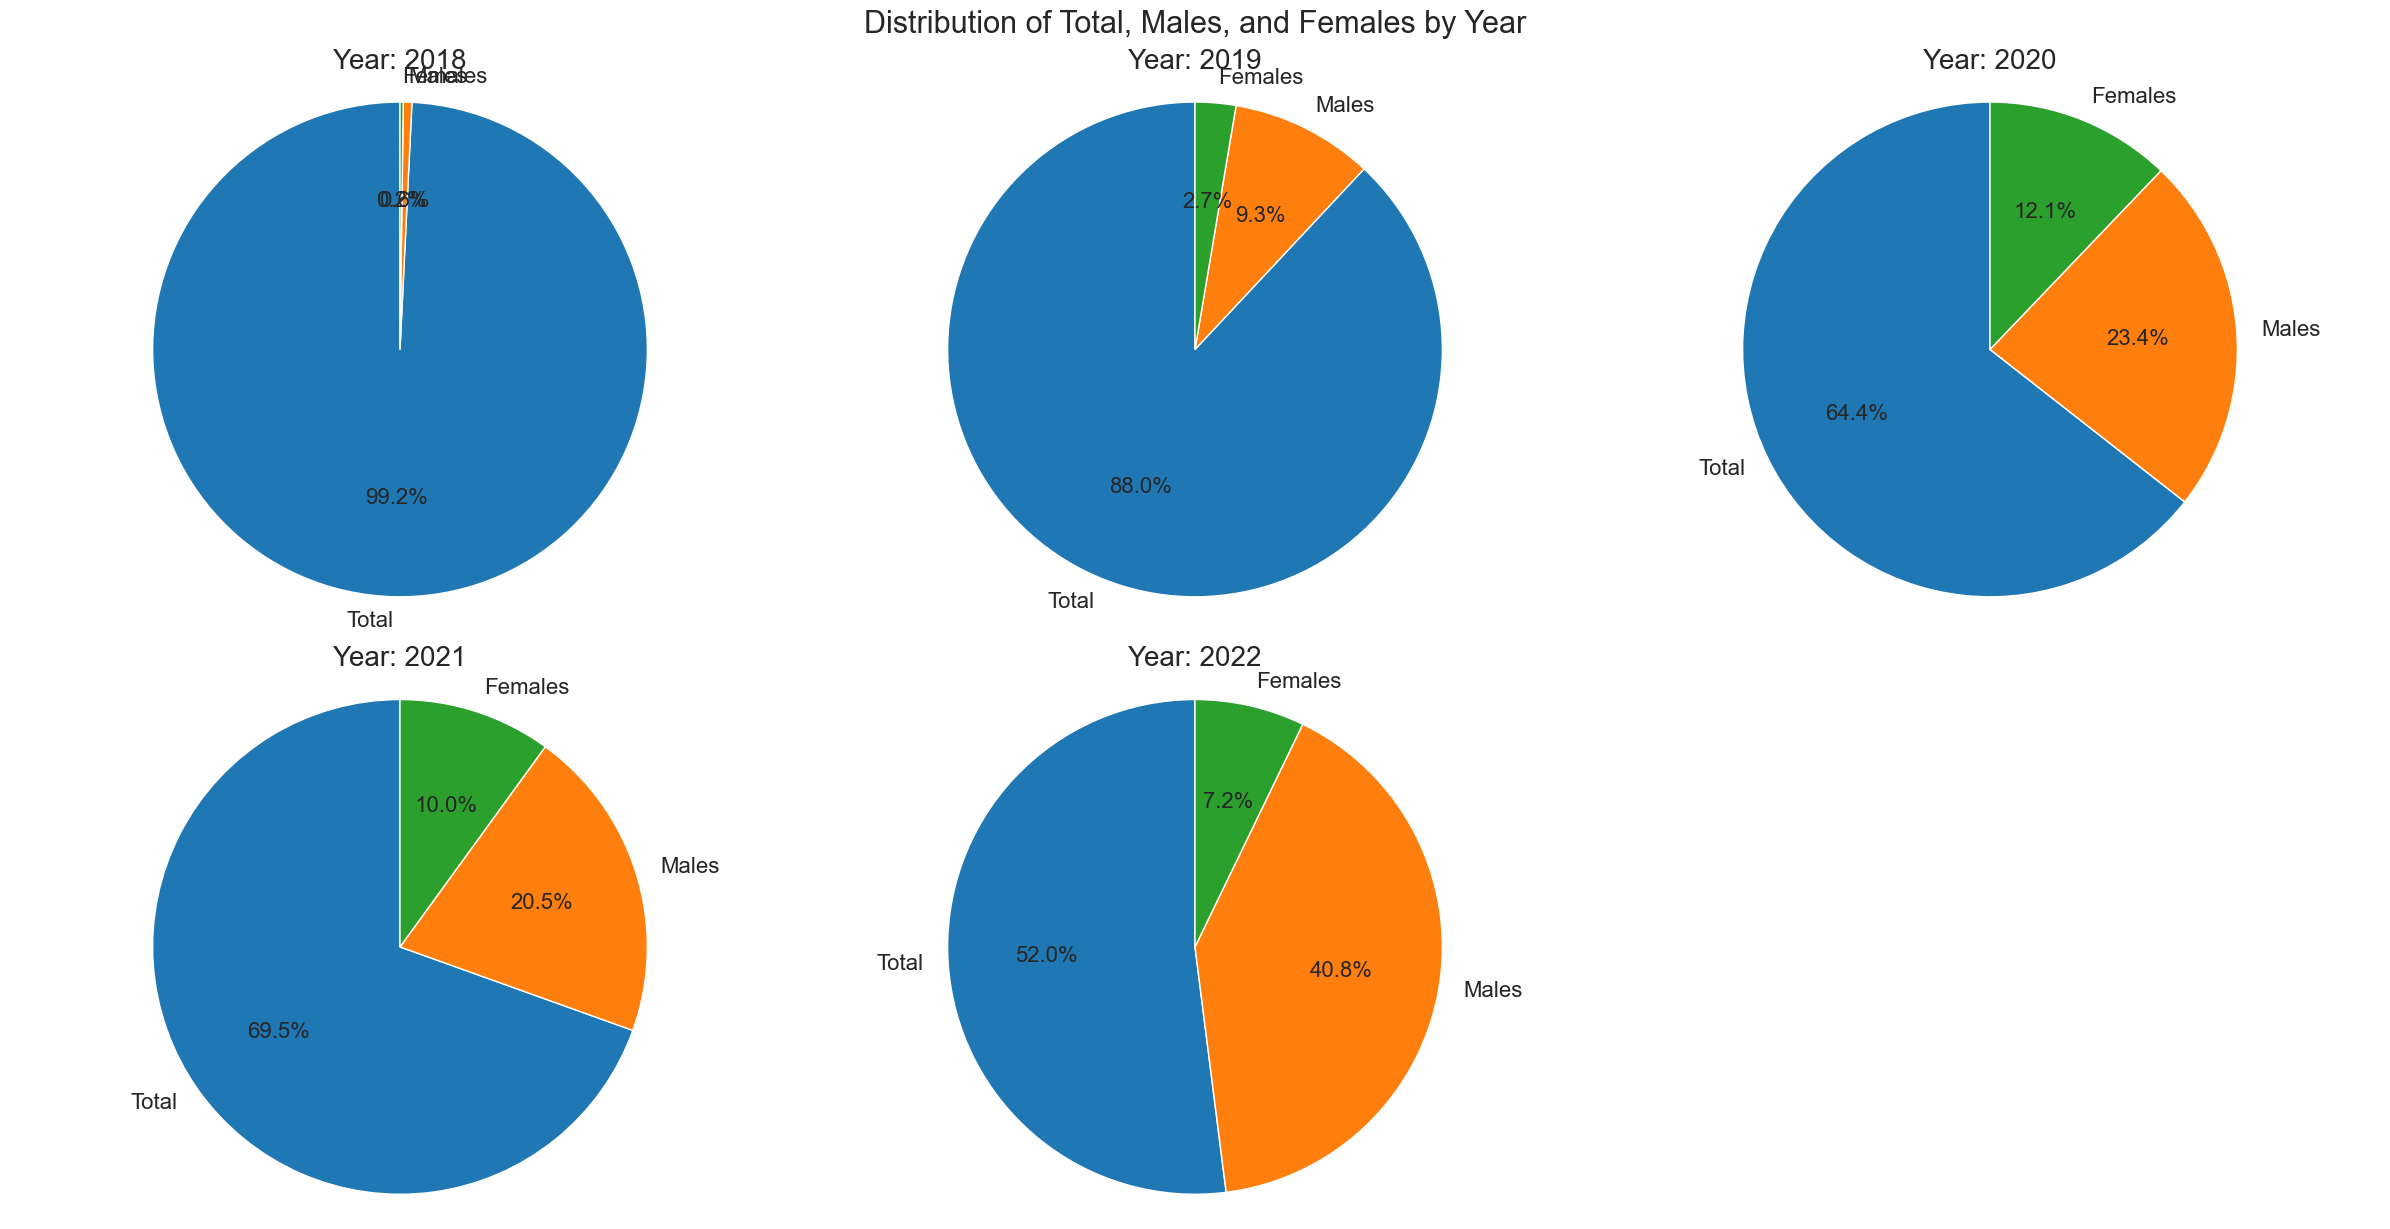

In [39]:
# Pivot the table to get gender as columns and number_of_treatments as values
pivot_df = edited_treatments_df.pivot_table(index='year', columns='gender', values='number_of_treatments', aggfunc='sum')

# If 'Total' is not present as a gender, calculate it as sum of 'Males' and 'Females'
if 'Total' not in pivot_df.columns:
    if 'Males' in pivot_df.columns and 'Females' in pivot_df.columns:
        pivot_df['Total'] = pivot_df['Males'] + pivot_df['Females']
    else:
        # Handle cases where 'Males' or 'Females' might also be missing.
        # This scenario needs to be handled based on user's definition of Total.
        # For now, it is assumed 'Total' will be a sum of 'Males' and 'Females'
        # if 'Total' column is missing or it will already be present in the df
        print("Warning: 'Total', 'Males', or 'Females' not found. Pie charts might not be accurate.")

# Select the columns for plotting, ensuring 'Total' is included for cases where it exists as a gender
# The user specifically asked for 'Total', 'Males', and 'Females', so I will use these columns for the plot.
# I will make sure the columns exist and are ordered for plotting.
columns_to_plot = ['Total', 'Males', 'Females']
available_columns = [col for col in columns_to_plot if col in pivot_df.columns]
data_to_plot = pivot_df[available_columns]

# Plotting the pie charts
num_years = len(data_to_plot)
cols = 3  # Number of columns for subplots
rows = (num_years + cols - 1) // cols  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, (year, data) in enumerate(data_to_plot.iterrows()):
    ax = axes[i]
    labels = data.index.tolist()
    sizes = data.values.tolist()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})
    ax.set_title(f'Year: {year}', fontsize=20)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribution of Total, Males, and Females by Year', y=1.02, fontsize=22)
plt.show()

As we can see, most early years don't provide gender-specific information, and as such making it hard to rely on it has a possible observed variable.

However, a few insights that we do gain is about the differences between drug consumption between men and women. It can be clearly seen that there are fewer cases of reported treatment cases of women than men. That said, it could be for external reasons - like countries (maybe more religious ones for example) that were reluctant to report such data.

We do see that in this case and the [trafficking incidents'](#442---trafficking-vs-possession-cases) case, this is a male dominant field, so it is somewhat explains the numbers. 

Last thing we want to check before we dismiss `gender` as a viable variable to consider in our model is to see its correlation with the total value reported.

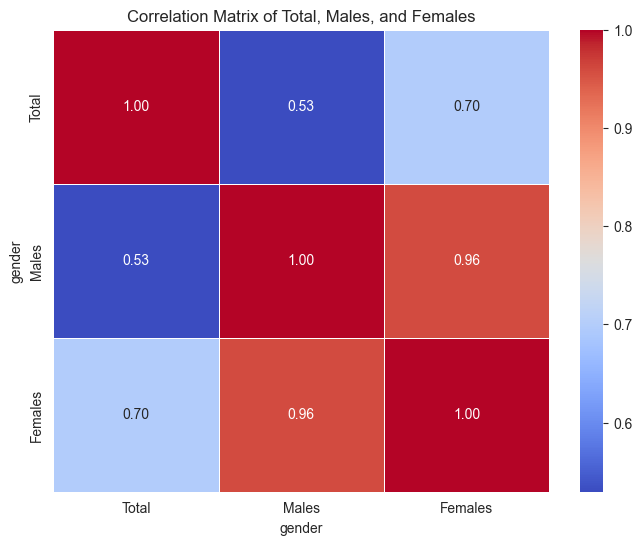

In [40]:
# Select the columns for correlation calculation
columns_for_correlation = [col for col in ['Total', 'Males', 'Females'] if col in pivot_df.columns]
correlation_data = pivot_df[columns_for_correlation]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Total, Males, and Females')
plt.show()

From the correlation matrix we can see immediately that using both female and male is not advisable, since they're heavily correlated. With relation to the *Total* incidents, we see that both genders are correlated, albeit *Males* less so.

We will try to engineer a new variable that expresses the ratio between the two genders, and see if it is more correlated with the total value.


In [41]:
edited_treatments_df = dputil.convert_gender_to_ratio(edited_treatments_df, ['region', 'country', 'year', 'drug_group'], 'number_of_treatments', gender_values=['Females', 'Males'])


#### Lastly, we will analyze the treatments for different drug groups:

In [42]:
print("list of drug types")
pprint(edited_treatments_df['drug_group'].unique().tolist())

list of drug types
['Amphetamine-type stimulants',
 'Any drug',
 'Cannabis-type drugs',
 'Non-specified',
 'Other drugs / psychoactive substances / pharmaceutical products not listed '
 'above',
 'Cocaine-type drugs',
 'Opioids, including opiates and synthetic opioids',
 'Solvents and inhalants',
 'Hallucinogens',
 'Non-medical use of pharmaceutical sedatives and tranquillizers',
 '“Ecstasy”-type substances',
 'New psychoactive substances',
 'Other miscellaneous',
 'Substances not under international control']


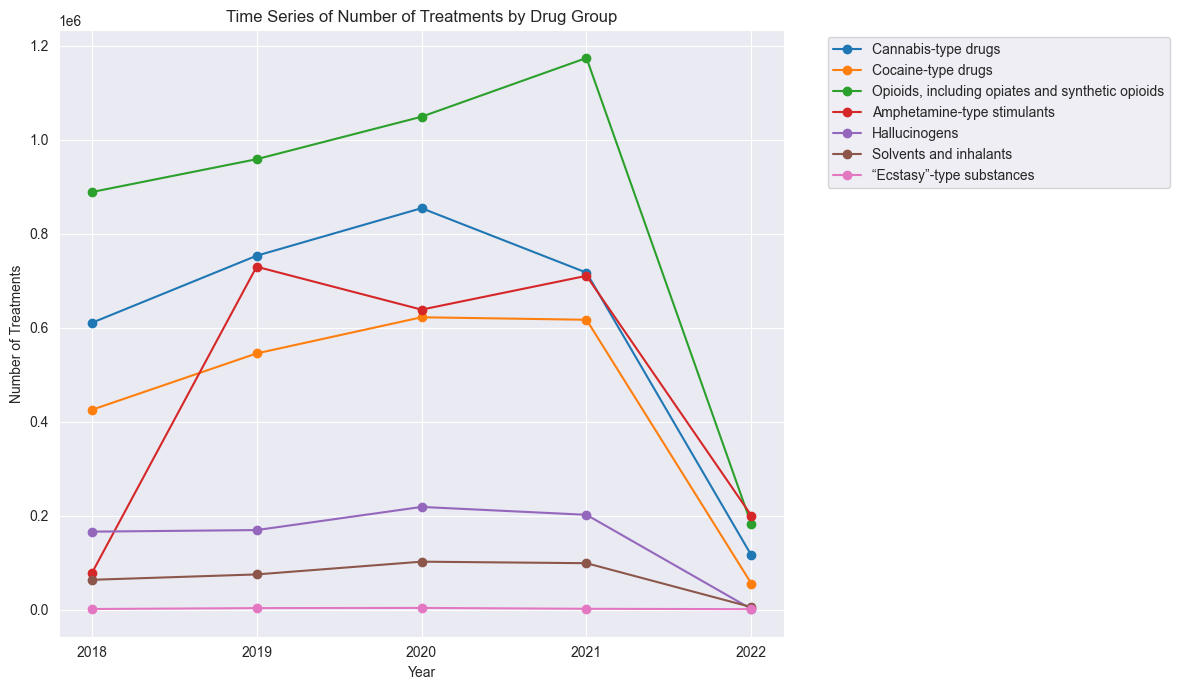

In [43]:
# Define the target drug groups
drug_groups_to_plot = [
    'Cannabis-type drugs',
    'Cocaine-type drugs',
    'Opioids, including opiates and synthetic opioids',
    'Amphetamine-type stimulants',
    'Hallucinogens',
    'Solvents and inhalants',
    '“Ecstasy”-type substances'
]

# Filter the DataFrame for the specified drug groups
filtered_df = edited_treatments_df[edited_treatments_df['drug_group'].isin(drug_groups_to_plot)]

# Aggregate the number_of_treatments by year and drug_group
time_series_data = filtered_df.groupby(['year', 'drug_group'])['total_treatments'].sum().unstack()

# Plotting the time-series
plt.figure(figsize=(12, 7))

for drug_group in drug_groups_to_plot:
    if drug_group in time_series_data.columns:
        plt.plot(time_series_data.index, time_series_data[drug_group], marker='o', label=drug_group)
    else:
        print(f"Warning: Data for '{drug_group}' not found in the filtered dataset.")

plt.xlabel('Year')
plt.xticks(time_series_data.index)
plt.ylabel('Number of Treatments')
plt.title('Time Series of Number of Treatments by Drug Group')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Interestingly, we see the most treatments were given to the *Opioids* and *Amphetamines* drug types, which were less common than *Cocaine* or *Cannabis* in the trafficking and seizure datasets. This then indicates that these types of drugs are **more dangerous** than the other.

Like in the case which the [continental analysis](#4521---analysis-of-yearly-counts-of-treatments-by-continent) had a steep incline in 2022, we suspect that this is due to the *US*'s missing values, being a country that is known to suffer from consumptions of such drugs (see [article.1](https://hsph.harvard.edu/news/what-led-to-the-opioid-crisis-and-how-to-fix-it/) and [article.2](https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2025.1460341/full)).

---

#### Section 4.6 - CIA FactBook for border data

figure 4.6.a) world map with internal borders in red and coastlines in blue



<img src="world_border_map.png" alt="world map with internal borders in red and coastlines in blue" width="800" height="600">

#### 4.6.1 - data manipulation:

In this section our aim is to convert both border length and coastline length from textual variable to numerical ones, by omitting the unit values (km) and any other non-numerical value in the description.

In [44]:
column_names = {
    "Country": "country",
    "Geography: Land boundaries - total": "border_length_km",
    "Geography: Coastline": "coastline_length_km"
}
borders_df_edited = borders_df.rename(columns=column_names)

# for "border_length_km" remove all non-numerical values
def handle_textual_borders(x: Union[str, float]) -> Union[list, str]:
    if pd.isna(x):
        return "-1"
    else:
        x = x.replace(",", "")
        numerics = [y for y in x.split(' ') if y.isnumeric()]
        if len(numerics) < 1:
            return "-1"
        else:
            return numerics[0]
borders_df_edited["border_length_km"] = borders_df_edited["border_length_km"].apply(handle_textual_borders).astype(int)
borders_df_edited["coastline_length_km"] = borders_df_edited["coastline_length_km"].apply(handle_textual_borders).astype(int)
borders_df_edited.sample(10, random_state=SEED)

,country,border_length_km,coastline_length_km
66,Djibouti,528,314
45,Central African Republic,5920,0
9,Antigua and Barbuda,0,153
73,Eritrea,1840,2234
136,Liberia,1667,579
104,Hong Kong,33,733
205,Senegal,2684,531
247,Vanuatu,0,2528
125,Kingman Reef,0,-1
211,Slovakia,1587,0


as we can see, there are some territories that are not countries (like `Kingman Reef`), therefore they're irrelevant in our analysis. We'll remove such values before we merge this dataset with the others.

There are also some countries with missing information, that we'll add manually.

In [45]:
borders_df_edited.query("coastline_length_km < 0").head(50)
# borders_df_edited.query("border_length_km < 0 or coastline_length_km < 0").head(50)

,country,border_length_km,coastline_length_km
1,Akrotiri,-1,-1
12,Aruba,0,-1
13,Ashmore and Cartier Islands,0,-1
19,Baker Island,0,-1
23,Belgium,1297,-1
31,Bouvet Island,0,-1
49,Christmas Island,0,-1
50,Clipperton Island,0,-1
65,Dhekelia,-1,-1
83,French Southern and Antarctic Lands,0,-1


In [46]:
cq = "Montenegro"
print(cq in legalization_df_sorted["country"].unique())
print(cq in final_seizures_df["country"].unique())
print(cq in edited_treatments_df["country"].unique())
print(cq in edited_crime_counts_df["country"].unique())
print(cq in demographics_df_edited["country"].unique())

True
True
True
True
True


In [47]:
# The data was extracted with the help of ChatGPT, with our manual validation of selected values
inland_border_manual_insert = {
    "Botswana": 4347,
    "Gibraltar": 1,
    "Italy": 1836,
    "Spain": 1928,
    "Morocco": 2019,
    "Zambia": 5664,
}
coastline_length_manual_insert = {
    "Belgium": 65,
    "Montenegro": 294,
    "Slovenia": 47,
    "Taiwan": 1566
}
borders_df_edited["border_length_km"] = borders_df_edited["border_length_km"].apply(lambda x: inland_border_manual_insert[x] if x in inland_border_manual_insert.keys() else x)
borders_df_edited["coastline_length_km"] = borders_df_edited["coastline_length_km"].apply(lambda x: coastline_length_manual_insert[x] if x in coastline_length_manual_insert.keys() else x)


---

# Sub-Section 5 - Merging dataframes and further analysis

Now that we are done processing each dataset individually, we would want to merge them together.

**Combination process**:

5.1) `legalization_df_sorted` + `final_seizures_df` = `merged_df`

5.2) `merged_df` += `edited_crime_counts_df`

5.3) `merged_df` += `edited_treatments_df`

5.4) `merged_df` += `demographics_df_edited`

5.5) `merged_df` += `borders_df_edited`

5.6) Further analysis - potential correlations, splicing etc.

<BR><BR>

---


## 5.1 - merging *legalization_df_sorted* and *final_seizures_df*

### 5.1.1 - initial merging process

In [48]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="outer", validate="many_to_one")

Now we'll check the countries what countries didn't align properly:

In [49]:
merged_df[pd.isna(merged_df['legal_category'])]["country"].unique()

array(['Aruba', 'Bolivia (Plurinational State of)', 'Brunei Darussalam',
       'Cabo Verde', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China', 'Czechia', "Côte d'Ivoire",
       'Eswatini', 'Iran (Islamic Republic of)',
       "Lao People's Democratic Republic", 'Republic of Korea',
       'Republic of Moldova', 'Russian Federation', 'State of Palestine',
       'Syrian Arab Republic', 'Timor-Leste', 'Türkiye',
       'United Republic of Tanzania', 'United States of America',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Zimbabwe'],
      dtype=object)

In [50]:
merged_df.query("seizure_volume.isnull() & legal_category != 'ILL'")["country"].unique()


array(['Bermuda', 'Bolivia', 'Czech Republic', 'Dominica', 'Korea, South',
       'Moldova', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'San Marino', 'Turkey',
       'Vanuatu'], dtype=object)

List of countries/territories that were removed due to missing values:
- <span style="color: #006400;">Aruba (missing legalization status)</span>
- <span style="color: #006400;">Palestine (missing legalization status)</span>
- <font color="green">Bermuda (missing traffic data)</font>
- <font color="green">Dominica (missing traffic data)</font>
- <font color="green">Rwanda (missing traffic data)</font>
- <font color="green">Saint Kitts and Nevis (missing traffic data)</font>
- <font color="green">Saint Lucia (missing traffic data)</font>
- <font color="green">Saint Vincent and the Grenadines (missing traffic data)</font>
- <font color="green">San Marino (missing traffic data)</font>
- <font color="green">Vanuatu (missing traffic data)</font>


Countries that were added to the list after searching their cannabis legality status:
- Gibraltar (ILL)
- Armenia (ILL)


Additionally - we have changed the names of some countries in order to merge the two datasets correctly. We arbitrarily decided to change the names in  *seizure_df*:

| Old name | New name |
| --- | --- |
| Bolivia (Plurinational State of) | Bolivia |
| Brunei Darussalam | Brunei |
| Cabo Verde | Cape Verde |
| China | People's Republic of China (PRC) |
| China, Hong Kong SAR | Hong Kong |
| China, Macau SAR | Macau, SAR of China |
| China, Taiwan Province of China | Taiwan |
| Czechia | Czech Republic |
| Côte d'Ivoire | Ivory Coast |
| Eswatini | Eswatini (Swaziland) |
| Iran (Islamic Republic of) | Iran |
| Lao People's Democratic Republic | Laos |
| Republic of Korea | Korea, South |
| Republic of Moldova | Moldova |
| Russian Federation | Russia |
| Syrian Arab Republic | Syria |
| Timor-Leste | East Timor |
| Türkiye | Turkey |
| United Republic of Tanzania | Tanzania |
| United States of America | United States |
| Venezuela (Bolivarian Republic of) | Venezuela |

In [90]:
country_names_to_change = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "China": "People's Republic of China (PRC)",
    "China, Hong Kong SAR": "Hong Kong",
    "China, Macau SAR": "Macau, SAR of China",
    "China, Macao SAR": "Macau, SAR of China",  # there are 2 variations
    "China, Taiwan Province of China": "Taiwan",
    "Czechia": "Czech Republic",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini": "Eswatini (Swaziland)",
    "Holy See": "Vatican City",
    "Iran (Islamic Republic of)": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Korea": "Korea, South",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "East Timor",
    "Türkiye": "Turkey",
    "United Republic of Tanzania": "Tanzania",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam"
}

In [52]:
final_seizures_df['country'] = final_seizures_df['country'].replace(country_names_to_change)

rows_to_add_to_legalization_df = [
    {"country": "Armenia", "legal_category": "ILL"},
    {"country": "Gibraltar", "legal_category": "ILL"},
]

legalization_df_sorted = pd.concat([legalization_df_sorted, pd.DataFrame(data=rows_to_add_to_legalization_df, columns=legalization_df_sorted.columns)], ignore_index=True)

Repeating the merge sequence after our changes. By using an inner join matching mechanism, we remove all territories with missing information as mentioned above.

In [53]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="inner")
merged_df.sample(10, random_state=SEED).sort_values("legal_category")

,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume,legal_category,recreational_year,medical_year,decriminalized_max_possession
3148,Europe,Estonia,Cannabis-type drugs (excluding synthetic canna...,Cannabis seed,2022,0.00021,DEC,NaN,NaN,7.5
1073,Asia,People's Republic of China (PRC),Sedatives and tranquillizers,Reported total sedatives and tranquillizers,2022,81.50000,ILL,NaN,NaN,NaN
5304,North America,United States,Hallucinogens,LSD,2022,30.00000,ILL,NaN,NaN,NaN
1321,Asia,India,Sedatives and tranquillizers,Benzodiazepines,2021,9.09524,ILL,NaN,NaN,NaN
5955,South America,Venezuela,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2021,6016.47500,ILL,NaN,NaN,20.0
1720,Asia,Malaysia,Opioids,Opiates,2018,1441.00000,ILL,NaN,NaN,NaN
2157,Asia,Thailand,Opioids,Opiates,2020,2299.49405,LGL,2022.0,2018.0,NaN
5466,Oceania,New Zealand,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,2018,4543.00000,MED,NaN,2018.0,27.0
5011,Europe,Turkey,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,2279.00000,MED,NaN,2016.0,NaN
4378,Europe,Romania,Cannabis-type drugs (excluding synthetic canna...,Cannabis oil,2022,0.22048,MED,NaN,2013.0,NaN


---

## 5.2 - adding *edited_crime_counts_df*

### 5.2.1 - analyze difference in columns before merge

In [54]:
edited_crime_counts_df.columns

Index(['region', 'sub_region', 'country', 'year', 'offence_type', 'drug_group',
       'calculated_total', 'crime_count_gender_ratio'],
      dtype='object')

In [55]:
merged_df.columns

Index(['region', 'country', 'drug_group', 'drug_sub_group',
       'seizure_reference_year', 'seizure_volume', 'legal_category',
       'recreational_year', 'medical_year', 'decriminalized_max_possession'],
      dtype='object')

In [56]:
# region:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "region", "region")

columns region and region in dataframes are the same!


In [57]:
# country:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "country", "country")

missing values from df1.country: {'Hong Kong', 'Bolivia', 'Dominican Republic', 'Iran', 'Madagascar', 'Sudan', 'Venezuela', "People's Republic of China (PRC)", 'Guyana', 'Moldova', 'Cape Verde', 'Azerbaijan', 'Afghanistan', 'United States', 'Russia', 'Brunei', 'Chad', 'Antigua and Barbuda', 'Korea, South', 'Norway', 'Seychelles', 'Jamaica', 'Syria', 'Kuwait', 'Tanzania', 'Liberia', 'Jordan', 'Georgia', 'Macau, SAR of China', 'Taiwan', 'East Timor', 'Libya', 'Barbados', 'Laos', 'Vietnam', 'Cameroon', 'United Arab Emirates', 'Turkey', 'Angola', 'Ivory Coast', 'Guinea', 'Eswatini (Swaziland)', 'Maldives', 'Czech Republic', 'Bahrain', 'Belize', 'Mauritania'}


missing values from df2.country: {'China, Hong Kong SAR', "Côte d'Ivoire", 'United States of America', 'Bolivia (Plurinational State of)', 'Iran (Islamic Republic of)', 'Holy See', 'Czechia', 'Syrian Arab Republic', 'State of Palestine', 'China, Macao SAR', 'Republic of Moldova', 'Venezuela (Bolivarian Republic of)', 'Russian Federat

In [58]:
# fix discrepancies in country names
crime_counts_df_for_merge = edited_crime_counts_df.copy()
crime_counts_df_for_merge['country'] = crime_counts_df_for_merge['country'].replace(country_names_to_change)


In [59]:
# year
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "seizure_reference_year", "year")

columns seizure_reference_year and year in dataframes are the same!


In [60]:
# drug_group
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "drug_group", "drug_group")

missing values from df1.drug_group: {'Amphetamine-type stimulants (excluding “ecstasy”)', '“Ecstasy”-type substances', 'Cannabis-type drugs (excluding synthetic cannabinoids)'}


missing values from df2.drug_group: {'Any Illicit drugs', 'Solvents and inhalants', 'Non-specified', 'Heroin', 'Non-specified substances not under int. control', 'Other Plant-based substances', 'Multiple Drugs', 'Ecstasy-type substances', 'Synthetic cathinones', 'Cannabis oil', 'Marijuana (herb)', 'Pharmaceutical opioids', 'Other miscellaneous', 'Other substances not under int. control', 'Coca paste/cocaine base', 'GBL', 'Plant-based NPS', 'Cannabis-type', 'Other types of cannabis', 'Benzodiazepines', 'Other NPS', 'GHB', 'Other opioids not under international control', 'Other stimulants', 'Ketamine and phencyclidine-type substances', 'Crack', 'Methamphetamine', 'ATS', 'Hashish (resin)'}


Since there are too many discrepancies, we will check for the possibility of removing all `drug_group` that are not `Any Illict Drug` which exists for all countries in all years:

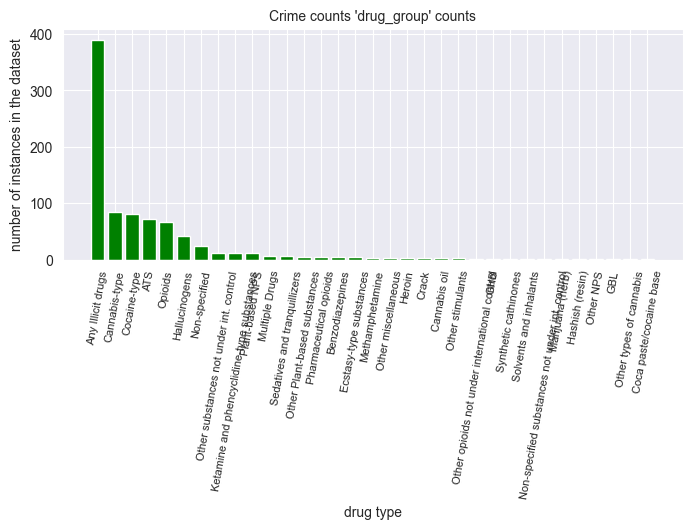

In [61]:
drug_group_instances = {}
for country_year, group in edited_crime_counts_df.groupby(['country', 'year']):
    for drug_group in group['drug_group'].unique():
        if drug_group not in drug_group_instances:
            drug_group_instances[drug_group] = 1
        else:
            drug_group_instances[drug_group] += 1

drug_group_instances = dict(sorted(drug_group_instances.items(), key=lambda x: x[1], reverse=True))

vis_utils.plot_regular_barplot(list(drug_group_instances.keys()), list(drug_group_instances.values()),
                               title="Crime counts 'drug_group' counts", xlabel="drug type", ylabel="number of instances in the dataset", color='green', xticks_rotation=80, figsize=(8, 3), xticks_fontsize=8
                               )

as we can see from the barchart above, even the 2nd highest value after *Any Illicit Drugs* - *Cannabis Type*, is far less abundant than what is required to merge the datasets correctly. Therefore, we will now filter out all non *Any Illicit Drugs* category, and remove the feature.

Additionally, we will re

#### merge dataframes

In [62]:
crime_counts_df_for_merge = crime_counts_df_for_merge[edited_crime_counts_df['drug_group'] == 'Any Illicit drugs']
crime_counts_df_for_merge.drop(columns=['drug_group', 'sub_region'], inplace=True)
crime_counts_df_for_merge = crime_counts_df_for_merge.rename(columns={"year": "drug_crime_ref_year",
                                                                "calculated_total": "total_crime_cases"})

In [63]:
merged_df = pd.merge(merged_df, crime_counts_df_for_merge, how="left", left_on=["region", "country", "seizure_reference_year"], right_on=["region", "country", "drug_crime_ref_year"])
merged_df = merged_df.drop(columns=["drug_crime_ref_year"])

---

## 5.2 - adding *treatments_df*

### 5.2.1 - analyze difference in columns before merge

In [64]:
print(f"{'*'*22}  merged_df  {'*'*22}", merged_df.columns)
print(f"{'*'*22}  treatments_df  {'*'*22}", edited_treatments_df.columns)

**********************  merged_df  ********************** Index(['region', 'country', 'drug_group', 'drug_sub_group',
       'seizure_reference_year', 'seizure_volume', 'legal_category',
       'recreational_year', 'medical_year', 'decriminalized_max_possession',
       'offence_type', 'total_crime_cases', 'crime_count_gender_ratio'],
      dtype='object')
**********************  treatments_df  ********************** Index(['country', 'year', 'drug_group', 'total_treatments', 'gender_ratio'], dtype='object')


Check for discrepancies in the following columns:
- country
- drug_group
- drug_sub_group

In [65]:
dputil.print_discrepancies(merged_df, edited_treatments_df, "country", "country")

missing values from df1.country: {'Hong Kong', 'Bolivia', 'Dominican Republic', 'Iran', 'Sudan', 'Japan', 'Paraguay', 'Bhutan', 'Israel', 'Venezuela', "People's Republic of China (PRC)", 'Guyana', 'Moldova', 'Guinea-Bissau', 'India', 'Cape Verde', 'Afghanistan', 'United States', 'Russia', 'Brunei', 'Chad', 'Pakistan', 'Korea, South', 'Jamaica', 'Syria', 'Kuwait', 'Tanzania', 'Liberia', 'Gambia', 'Macau, SAR of China', 'Taiwan', 'East Timor', 'Barbados', 'Vietnam', 'Laos', 'Cameroon', 'Iceland', 'Turkey', 'Ivory Coast', 'Canada', 'Eswatini (Swaziland)', 'Maldives', 'Czech Republic', 'Qatar', 'Namibia', 'Bahrain', 'Belize'}


missing values from df2.country: {'Brunei Darussalam', 'Iran (Islamic Republic of)', 'Republic of Moldova', 'Venezuela (Bolivarian Republic of)', 'Holy See', "Côte d'Ivoire", 'China, Hong Kong SAR', 'Czechia', "Lao People's Democratic Republic", 'Russian Federation', 'United Republic of Tanzania', 'Türkiye', 'Cabo Verde', 'China', 'United States of America', 'China,

In [66]:
 # fix discrepancies in country names
treatments_df_for_merge = edited_treatments_df.copy()
treatments_df_for_merge['country'] = treatments_df_for_merge['country'].replace(country_names_to_change)

In [67]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "country", "country")

missing values from df1.country: {'Bolivia', 'Dominican Republic', 'Sudan', 'Japan', 'Paraguay', 'Bhutan', 'Israel', 'Guyana', 'Guinea-Bissau', 'India', 'Afghanistan', 'Chad', 'Pakistan', 'Korea, South', 'Jamaica', 'Syria', 'Kuwait', 'Liberia', 'Gambia', 'Taiwan', 'East Timor', 'Barbados', 'Vietnam', 'Cameroon', 'Iceland', 'Eswatini (Swaziland)', 'Canada', 'Maldives', 'Qatar', 'Namibia', 'Bahrain', 'Belize'}


missing values from df2.country: {'Vatican City'}


In [68]:
missing_countries_in_treatments = {'Maldives', 'Jamaica', 'Paraguay', 'India', 'Syria', 'Barbados', 'Sudan', 'Canada', 'Japan', 'Cameroon', 'Guyana', 'Liberia', 'Belize', 'East Timor', 'Bahrain', 'Korea, South', 'Gambia', 'Pakistan', 'Afghanistan', 'Eswatini (Swaziland)', 'Israel', 'Vietnam', 'Bhutan', 'Namibia', 'Taiwan', 'Kuwait', 'Guinea-Bissau', 'Dominican Republic', 'Iceland', 'Qatar', 'Chad', 'Bolivia'}
merged_df.query("country in @missing_countries_in_treatments")[["country", "legal_category"]].drop_duplicates()["legal_category"].value_counts()

legal_category
ILL    23
MED     5
DEC     3
LGL     1
Name: count, dtype: int64

However unfortunate, we are unable to apply models and further analyses on the countries above, since we are missing our target variable.

In [69]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "drug_group", "drug_group")

missing values from df1.drug_group: {'Cannabis-type drugs (excluding synthetic cannabinoids)', 'Sedatives and tranquillizers', 'Opioids', 'Amphetamine-type stimulants (excluding “ecstasy”)', 'Cocaine-type'}


missing values from df2.drug_group: {'Any drug', 'Solvents and inhalants', 'Non-specified', 'Substances not under international control', 'Cannabis-type drugs', 'Other miscellaneous', 'New psychoactive substances', 'Amphetamine-type stimulants', 'Non-medical use of pharmaceutical sedatives and tranquillizers', 'Other drugs / psychoactive substances / pharmaceutical products not listed above', 'Opioids, including opiates and synthetic opioids', 'Cocaine-type drugs'}


In [ ]:
# align drug_group between treatments and the merged data:
drug_group_mapping_treatments = {
    'Cocaine-type drugs': 'Cocaine-type',
    'Amphetamine-type stimulants': 'Amphetamine-type stimulants (excluding “ecstasy”)',
    'Non-medical use of pharmaceutical sedatives and tranquillizers': 'Sedatives and tranquillizers',
    'Opioids, including opiates and synthetic opioids': 'Opioids',
    'Cannabis-type drugs': 'Cannabis-type drugs (excluding synthetic cannabinoids)',
    'New psychoactive substances': np.nan,
    'Non-specified': np.nan,
    'Other drugs / psychoactive substances / pharmaceutical products not listed above': np.nan,
    'Solvents and inhalants': np.nan,
    'Other miscellaneous': np.nan,
    'Any drug': np.nan,
    'Substances not under international control': np.nan
}

treatments_df_for_merge['drug_group'] = treatments_df_for_merge['drug_group'].replace(drug_group_mapping_treatments)
treatments_df_for_merge = treatments_df_for_merge.dropna(subset=['drug_group'])
treatments_df_for_merge = treatments_df_for_merge.rename(columns={"gender_ratio": "patient_gender_ratio"})

In [74]:
merged_df = pd.merge(merged_df, treatments_df_for_merge, how="inner", left_on=["country", "seizure_reference_year", "drug_group"], right_on=["country", "year", "drug_group"])
merged_df = merged_df.drop(columns=["year"])

#### Merging demographics data

In [75]:
pivoted_demographics_df.columns

Index(['country', 'Country Code', 'year', 'gdp', 'health_expenditure',
       'population', 'gdp_per_capita'],
      dtype='object', name='Series Name')

In [76]:
dputil.print_discrepancies(merged_df, pivoted_demographics_df, "country", "country")

missing values from df1.country: {'Hong Kong', "People's Republic of China (PRC)", 'Turkey', 'Kyrgyzstan', 'Slovakia', 'Macau, SAR of China', 'Egypt', 'Russia', 'Bahamas', 'Brunei', 'Czech Republic', 'Zambia', 'Laos', 'Venezuela'}


missing values from df2.country: {'Sint Maarten (Dutch part)', 'Tuvalu', 'Hong Kong SAR, China', "Korea, Dem. People's Rep.", 'Venezuela, RB', 'Vanuatu', 'Macao SAR, China', 'Monaco', 'Northern Mariana Islands', 'India', 'Channel Islands', 'Kyrgyz Republic', 'Antigua and Barbuda', 'Burundi', 'Kosovo', 'Fiji', 'Malawi', 'French Polynesia', 'Turkiye', 'Turks and Caicos Islands', 'Cameroon', 'Brunei Darussalam', 'Puerto Rico', 'Greenland', 'Viet Nam', 'Turkmenistan', 'Bahrain', 'Curacao', 'Equatorial Guinea', 'Bhutan', 'Dominica', 'Palau', 'Gambia, The', 'Guyana', 'New Caledonia', 'St. Lucia', 'St. Martin (French part)', 'Ethiopia', 'Papua New Guinea', 'Jamaica', 'Kuwait', 'Slovak Republic', 'St. Kitts and Nevis', 'Eswatini', 'South Sudan', 'Liechtenstein', 'U

In [77]:
demographics_df_for_merge = pivoted_demographics_df.copy()
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(country_names_to_change)
dputil.print_discrepancies(merged_df, demographics_df_for_merge, "country", "country")

missing values from df1.country: {'Hong Kong', 'Turkey', 'Kyrgyzstan', 'Slovakia', 'Macau, SAR of China', 'Egypt', 'Bahamas', 'Zambia', 'Laos', 'Venezuela'}


missing values from df2.country: {'Sint Maarten (Dutch part)', 'Tuvalu', 'Hong Kong SAR, China', "Korea, Dem. People's Rep.", 'Venezuela, RB', 'Vanuatu', 'Macao SAR, China', 'Monaco', 'Northern Mariana Islands', 'India', 'Channel Islands', 'Cape Verde', 'Kyrgyz Republic', 'Antigua and Barbuda', 'Burundi', 'Kosovo', 'Fiji', 'Malawi', 'French Polynesia', 'Turkiye', 'Turks and Caicos Islands', 'Cameroon', 'Puerto Rico', 'Greenland', 'Turkmenistan', 'Bahrain', 'Curacao', 'Equatorial Guinea', 'Bhutan', 'Dominica', 'Palau', 'Gambia, The', 'Guyana', 'New Caledonia', 'St. Lucia', 'St. Martin (French part)', 'Ethiopia', 'Papua New Guinea', 'Jamaica', 'Kuwait', 'Slovak Republic', 'St. Kitts and Nevis', 'South Sudan', 'Liechtenstein', 'Uganda', 'Vietnam', 'Canada', 'Comoros', 'Gabon', 'Maldives', 'Isle of Man', 'Qatar', 'Namibia', 'Belize',

In [78]:
update_country_dict = {
    'Macao SAR, China': 'Macau, SAR of China',
    'Hong Kong SAR, China': 'Hong Kong',
    'Turkiye': 'Turkey',
    'Slovak Republic': 'Slovakia',
    'Egypt, Arab Rep.': 'Egypt',
    'Venezuela, RB': 'Venezuela',
}
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(update_country_dict)

In [79]:
print_discrepancies(merged_df, demographics_df_for_merge, "seizure_reference_year", "year")

missing values from df1.seizure_reference_year: set()


missing values from df2.year: {np.int64(2017), np.int64(2023)}


In [80]:
demographics_df_for_merge = demographics_df_for_merge.drop(columns=["Country Code"])

In [83]:
merged_df = pd.merge(merged_df, demographics_df_for_merge, how="left", left_on=["country", "seizure_reference_year"], right_on=["country", "year"], suffixes=["", "_to_remove"])
merged_df = merged_df.drop(columns=["year"])

#### merging borders data

In [84]:
borders_df_edited.columns

Index(['country', 'border_length_km', 'coastline_length_km'], dtype='object')

In [85]:
print_discrepancies(merged_df, borders_df_edited, "country", "country")

missing values from df1.country: {"People's Republic of China (PRC)", 'Turkey', 'Macau, SAR of China', 'Czech Republic', 'Bahamas', 'Myanmar'}


missing values from df2.country: {'Heard Island and McDonald Islands', 'Tuvalu', 'Christmas Island', 'Iran', 'Vanuatu', 'Midway Islands', 'Monaco', 'Korea, North', 'Wallis and Futuna', 'Akrotiri', 'Tokelau', 'Norfolk Island', 'Niue', 'Northern Mariana Islands', 'Baker Island', 'Cook Islands', 'Bouvet Island', 'Jarvis Island', 'India', 'Saint Helena, Ascension, and Tristan da Cunha', 'Dhekelia', 'Antigua and Barbuda', 'Burundi', 'Kosovo', 'Saint Lucia', 'Fiji', 'Kingman Reef', 'Paracel Islands', 'Malawi', 'Jersey', 'French Polynesia', 'Turks and Caicos Islands', 'Palmyra Atoll', 'Cameroon', 'Puerto Rico', 'Greenland', 'Turkmenistan', 'Bahrain', 'Macau', 'Curacao', 'Congo, Republic of the', 'Clipperton Island', 'Howland Island', 'British Indian Ocean Territory', 'Saint Barthelemy', 'Equatorial Guinea', 'Bhutan', 'Dominica', 'Jan Mayen', 'Palau',

In [91]:
border_df_for_merge = borders_df_edited.copy()
country_names_to_change.update({
    "Czechia": "Czech Republic",
    "China": "People's Republic of China (PRC)",
    "Burma": "Myanmar",
    "Turkey (Turkiye)": "Turkey",
    "Macau": "Macau, SAR of China",
    "Bahamas, The": "Bahamas"
})
border_df_for_merge["country"] = border_df_for_merge["country"].replace(country_names_to_change)
print_discrepancies(merged_df, border_df_for_merge, "country", "country")

missing values from df1.country: set()


missing values from df2.country: {'Heard Island and McDonald Islands', 'Tuvalu', 'Christmas Island', 'Iran', 'Vanuatu', 'Midway Islands', 'Monaco', 'Korea, North', 'Wallis and Futuna', 'Akrotiri', 'Tokelau', 'Norfolk Island', 'Niue', 'Northern Mariana Islands', 'Baker Island', 'Cook Islands', 'Bouvet Island', 'Jarvis Island', 'India', 'Saint Helena, Ascension, and Tristan da Cunha', 'Cape Verde', 'Dhekelia', 'Antigua and Barbuda', 'Burundi', 'Kosovo', 'Saint Lucia', 'Fiji', 'Kingman Reef', 'Paracel Islands', 'Malawi', 'Jersey', 'French Polynesia', 'Turks and Caicos Islands', 'Palmyra Atoll', 'Cameroon', 'Puerto Rico', 'Greenland', 'Turkmenistan', 'Bahrain', 'Curacao', 'Congo, Republic of the', 'Clipperton Island', 'Howland Island', 'British Indian Ocean Territory', 'Saint Barthelemy', 'Equatorial Guinea', 'Bhutan', 'Dominica', 'Jan Mayen', 'Palau', 'Gambia, The', 'Pitcairn Islands', 'Guyana', 'Falkland Islands (Islas Malvinas)', 'New Caledonia',

In [92]:
merged_df = pd.merge(merged_df, border_df_for_merge, how="left", left_on=["country"], right_on=["country"])

### The final dataset, after preprocessing:

#### Dimensions: 5094x21

In [93]:
merged_df

,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume,legal_category,recreational_year,medical_year,decriminalized_max_possession,...,total_crime_cases,crime_count_gender_ratio,total_treatments,patient_gender_ratio,gdp,health_expenditure,population,gdp_per_capita,border_length_km,coastline_length_km
0,Africa,Algeria,Amphetamine-type stimulants (excluding “ecstasy”),Non-specified amphetamine-type stimulants,2018,452.00000,ILL,NaN,NaN,NaN,...,10035.0,0.015791,6850.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
1,Africa,Algeria,Amphetamine-type stimulants (excluding “ecstasy”),Non-specified amphetamine-type stimulants,2018,452.00000,ILL,NaN,NaN,NaN,...,41368.0,0.008828,6850.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
2,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2018,1.00000,ILL,NaN,NaN,NaN,...,10035.0,0.015791,6505.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
3,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2018,1.00000,ILL,NaN,NaN,NaN,...,41368.0,0.008828,6505.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
4,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2019,8.00000,ILL,NaN,NaN,NaN,...,9753.0,0.017103,4990.0,-1.0,1.934600e+11,5.417311,43294546.0,4468.461224,6734,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,South America,Venezuela,Sedatives and tranquillizers,Benzodiazepines,2022,0.09666,ILL,NaN,NaN,20.0,...,9033.0,-1.000000,2.0,0.0,NaN,4.550474,28213017.0,NaN,5267,2800
5090,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,0.00000,ILL,NaN,NaN,20.0,...,460.0,0.314286,7.0,-1.0,NaN,2.416913,29807592.0,NaN,5267,2800
5091,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,0.00000,ILL,NaN,NaN,20.0,...,10349.0,0.604496,7.0,-1.0,NaN,2.416913,29807592.0,NaN,5267,2800
5092,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2019,0.00000,ILL,NaN,NaN,20.0,...,3341.0,0.118514,2.0,-1.0,NaN,2.185637,28938098.0,NaN,5267,2800


In [96]:
merged_df.describe()

,seizure_reference_year,seizure_volume,recreational_year,medical_year,decriminalized_max_possession,total_crime_cases,crime_count_gender_ratio,total_treatments,patient_gender_ratio,gdp,health_expenditure,population,gdp_per_capita,border_length_km,coastline_length_km
count,5094.000000,5.094000e+03,402.000000,3031.000000,1165.000000,4433.000000,4433.000000,5094.000000,5094.000000,4.874000e+03,4877.000000,5.022000e+03,4874.000000,5094.000000,5094.000000
mean,2020.119749,3.017070e+04,2017.746269,2016.233256,12.275536,20304.198511,-0.075024,12505.010915,-0.285004,1.014892e+12,8.111134,3.701867e+07,29390.231638,2638.044170,4971.049274
std,1.400468,4.400050e+05,5.455812,3.818233,11.235684,47983.867639,0.488352,66269.131217,0.677337,3.364427e+12,2.789134,8.711870e+07,27304.784637,3436.639127,9001.227363
min,2018.000000,0.000000e+00,2009.000000,2003.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,1.487174e+09,1.817682,3.549400e+04,500.457186,-1.000000,-1.000000
25%,2019.000000,7.535900e-01,2013.000000,2013.000000,5.000000,777.000000,0.027397,53.000000,-1.000000,6.166813e+10,6.312910,4.985382e+06,8781.489199,499.000000,0.000000
50%,2020.000000,2.067675e+01,2021.000000,2016.000000,10.000000,3561.000000,0.106026,353.000000,0.017544,2.519920e+11,8.202748,1.046387e+07,20691.973899,1587.000000,1250.000000
75%,2021.000000,8.213880e+02,2023.000000,2018.000000,22.000000,18407.000000,0.155844,2433.000000,0.250000,5.984940e+11,9.953881,3.698156e+07,47487.217615,2816.000000,5835.000000
max,2022.000000,1.149658e+07,2024.000000,2025.000000,100.000000,498087.000000,4.500000,925333.333333,3.000000,2.368120e+13,18.813253,1.407745e+09,133711.794436,22457.000000,54716.000000


In [97]:
merged_df.describe(include='object')

,region,country,drug_group,drug_sub_group,legal_category,offence_type
count,5094,5094,5094,5094,5094,4433
unique,7,113,7,34,4,3
top,Europe,Sweden,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),MED,Offences related to drug trafficking
freq,3066,175,1754,526,2635,1867


In [98]:
merged_df.to_csv("data/final_dataframe.csv", index=False)

## Additional EDA:
#### 1. Representation in 2D space
#### 2. Correlations

The representation will be represented using tSNE

In [156]:
def prep_data_for_tsne(df: pd.DataFrame, filtering_query: str = '', numerical_imputation: str = 'median', categorical_imputation: str = 'most_frequent') -> pd.DataFrame:
    """
    Preprocesses the input DataFrame for t-SNE visualization.
    This includes filtering, imputing missing values (numerical and categorical),
    one-hot encoding categorical features, and scaling numerical features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        filtering_query (str): A query string to filter the DataFrame (e.g., "year == 2022").
                               If empty, no filtering is applied.
        numerical_imputation (str): Strategy for numerical imputation ('mean', 'median', 'most_frequent', 'constant').
        categorical_imputation (str): Strategy for categorical imputation ('most_frequent', 'constant').

    Returns:
        pd.DataFrame: A scaled DataFrame ready for t-SNE, with original index preserved.
    """

    # Filter the dataframe
    fdf = df.query(filtering_query).copy() if filtering_query else df.copy()

    # Separate numerical and categorical columns
    numerical_cols = fdf.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = list(set(fdf.columns) - set(numerical_cols))

    df_numerical = fdf[numerical_cols]
    df_categorical = fdf[categorical_cols]

    # Impute missing values in numerical features
    numerical_imputer = SimpleImputer(strategy=numerical_imputation)
    # Convert imputed array back to DataFrame with original columns and index
    df_num_imputed = pd.DataFrame(
        numerical_imputer.fit_transform(df_numerical),
        columns=numerical_cols,
        index=fdf.index
    )

    # Impute missing values in categorical features
    categorical_imputer = SimpleImputer(strategy=categorical_imputation)
    X_categorical_imputed = {}
    for col in df_categorical.columns:
        X_categorical_imputed[col] = categorical_imputer.fit_transform(df_categorical[[col]]).flatten().tolist()

    encoded_features_df = pd.DataFrame(X_categorical_imputed)

    # One-hot encode all categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(df_categorical)
    encoded_features_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=fdf.index
    )

    # Concatenate imputed numerical and one-hot encoded categorical features
    # Now both are DataFrames, so concatenation will work
    df_combined_features = pd.concat([df_num_imputed, encoded_features_df], axis=1)

    # Perform scaling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df_combined_features)

    # Return as DataFrame with original index, in case it's useful for subsequent steps
    scaled_df = pd.DataFrame(scaled_array, columns=df_combined_features.columns, index=fdf.index)

    return scaled_df

def plot_tsne(df_scaled: pd.DataFrame, color_data: pd.Series, title: str = '', perplexity: int = 30, random_state: int = 42, legend_title: str = None, colorbar: bool = False) -> None:
    """
    Plots t-SNE visualization of the given scaled data.

    Args:
        df_scaled (pd.DataFrame): The preprocessed and scaled DataFrame ready for t-SNE.
        color_data (pd.Series): A Series containing the data to be used for coloring points (e.g., 'total_treatments' or 'legal_category').
                                 Its index should align with df_scaled's index.
        title (str): Title of the plot.
        perplexity (int): Perplexity parameter for t-SNE.
        random_state (int): Random state for reproducibility.
        legend_title (str): Title for the legend or colorbar.
        colorbar (bool): If True, attempts to display a colorbar (for numerical color_data).
                         If False, displays a standard legend (for categorical or if colorbar not desired).
    """
    # Adjust perplexity based on data size to avoid error
    actual_perplexity = min(perplexity, len(df_scaled) - 1)
    if actual_perplexity <= 0:
        print("Not enough data points for t-SNE with a positive perplexity. Skipping plot.")
        return

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=actual_perplexity)
    tsne_results = tsne.fit_transform(df_scaled)

    # Create a DataFrame for t-SNE results
    tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne_component_1', 'tsne_component_2'], index=df_scaled.index)
    tsne_df['coloring'] = color_data.reindex(tsne_df.index) # Ensure color_data aligns with tsne_df index

    # Plotting
    plt.figure(figsize=(16, 14)) # Increased figure size
    is_numerical_hue = pd.api.types.is_numeric_dtype(tsne_df['coloring'])

    ax = sns.scatterplot( # Assign the Axes object to 'ax'
        x='tsne_component_1',
        y='tsne_component_2',
        hue='coloring',
        palette='viridis' if is_numerical_hue else 'tab10', # Use viridis for numerical, tab10 for categorical
        data=tsne_df,
        legend='full', # This will make seaborn automatically create a colorbar/legend
        s=200, # Increased point size
        alpha=0.7
    )

    plt.title(title, fontsize=22) # Increased title font size
    plt.xlabel('t-SNE Component 1', fontsize=20) # Increased x-axis label font size
    plt.ylabel('t-SNE Component 2', fontsize=20) # Increased y-axis label font size
    plt.xticks(fontsize=18) # Increased x-axis tick label font size
    plt.yticks(fontsize=18) # Increased y-axis tick label font size

    if colorbar and is_numerical_hue:
        # Explicitly create and configure the colorbar using plt.colorbar
        # This is more robust than relying on ax.collections[0].colorbar
        norm = plt.Normalize(tsne_df['coloring'].min(), tsne_df['coloring'].max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax, orientation='vertical') # Use 'ax' to associate with the subplot
        cbar.set_label(legend_title if legend_title else 'Value', fontsize=20)
        cbar.ax.tick_params(labelsize=18)
        ax.get_legend().remove()
    else: # For categorical hue, or if colorbar=False
        if ax.legend_ is not None:
            legend = ax.legend_
            plt.setp(legend.get_title(), fontsize=20)
            plt.setp(legend.get_texts(), fontsize=18)
            if legend_title:
                legend.set_title(legend_title) # Set legend title

    plt.grid(True)
    plt.tight_layout()
    plt.show() # Display the plot

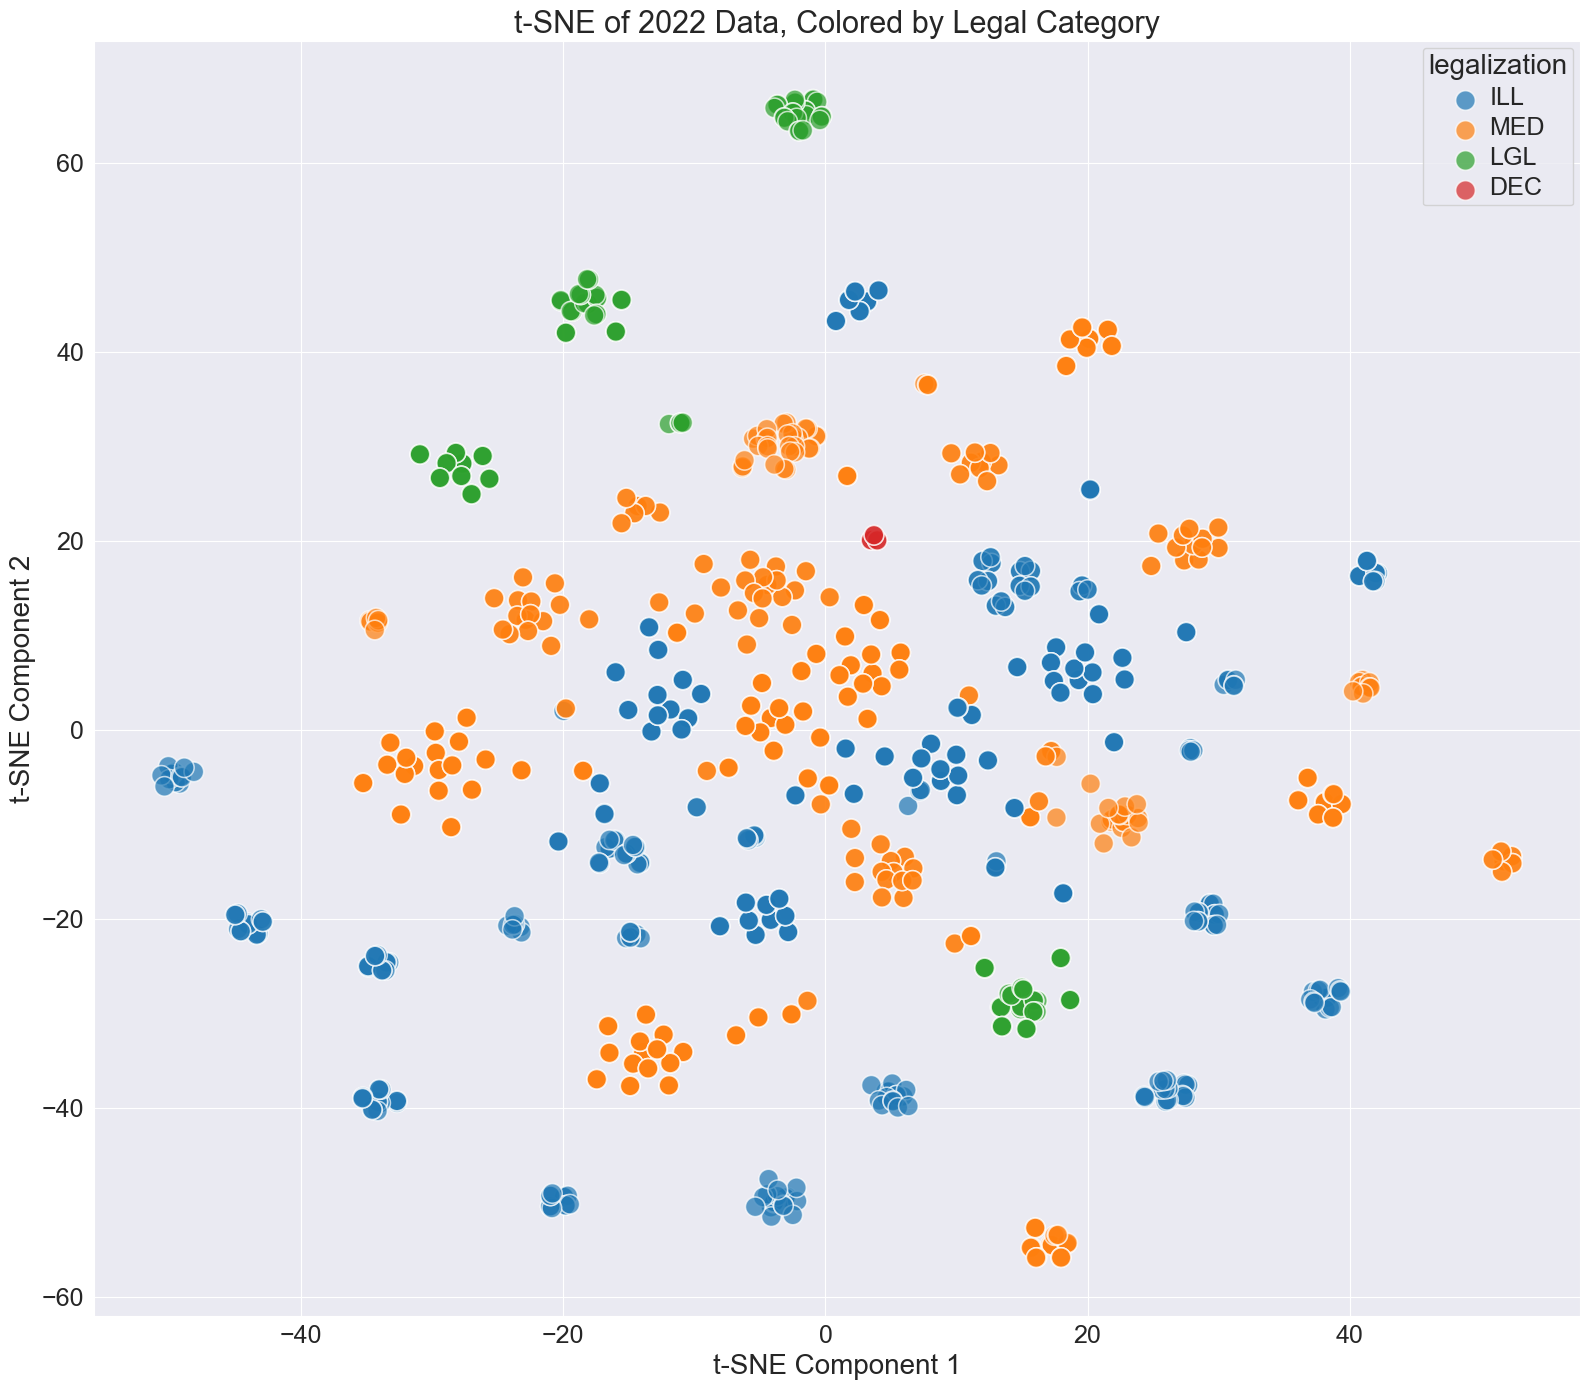

In [152]:
tsne_legal_cat_df = prep_data_for_tsne(merged_df, filtering_query='seizure_reference_year == 2022', numerical_imputation='median', categorical_imputation='most_frequent')
plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['legal_category'], title="t-SNE of 2022 Data, Colored by Legal Category", legend_title='legalization', perplexity=30, random_state=SEED)

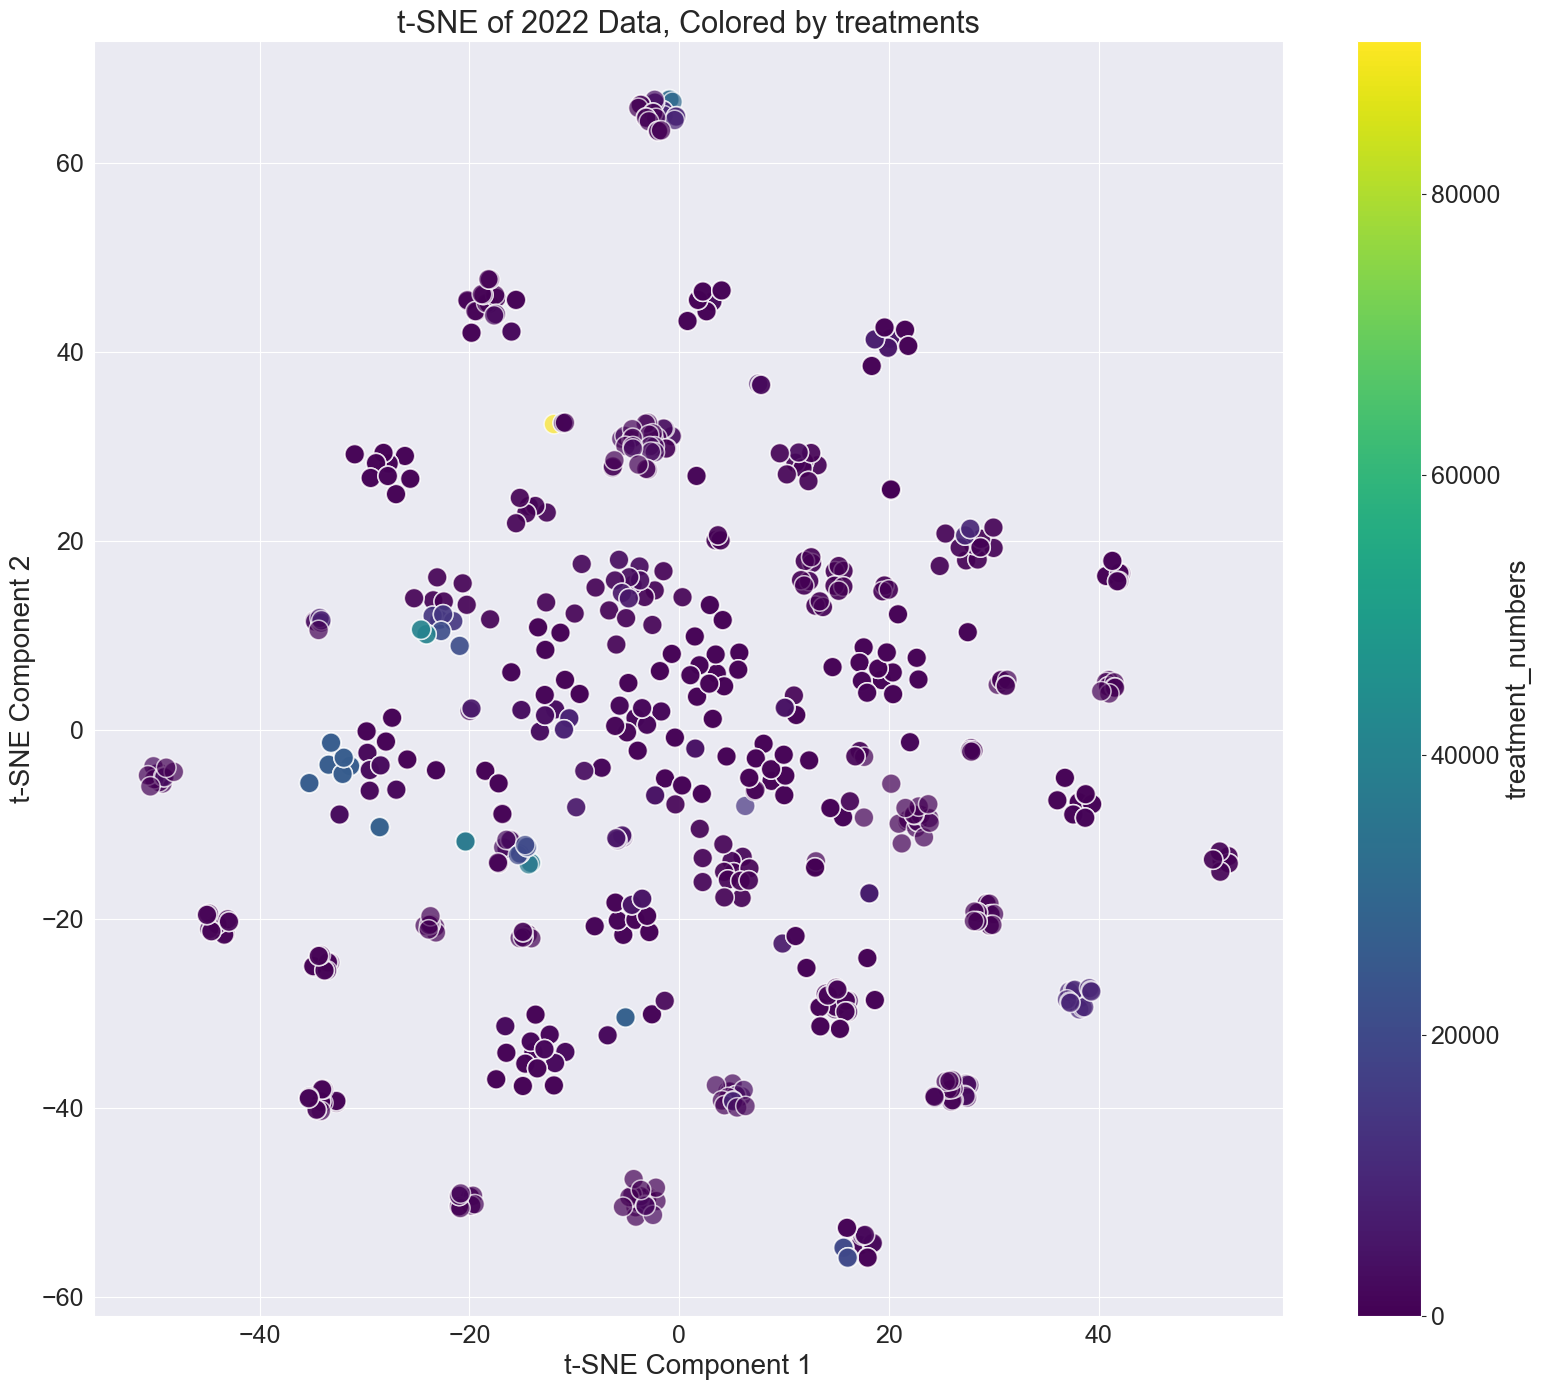

In [157]:
plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['total_treatments'], title="t-SNE of 2022 Data, Colored by treatments", colorbar=True, legend_title='treatment_numbers', perplexity=30, random_state=SEED)